In [23]:
import pandas as pd

from octopus.db import PostgresqlManager
from dotenv import load_dotenv

import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

import numpy as np

from datetime import datetime
from tqdm import tqdm
import seaborn as sns


In [24]:
def get_congress_number(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    year = date.year

    # Assuming congress starts from 1789
    if year >= 1789:
        congress_number = (year - 1789) // 2 + 1
        return f"{congress_number}th"
    else:
        return 'Unknown'

In [25]:
# get senator-ticker pair

load_dotenv("/Users/syyun/Dropbox (MIT)/efd/.envlv", override=True)
pm = PostgresqlManager(dotenv_path="/Users/syyun/Dropbox (MIT)/efd/.envlv")
transc_data = pm.execute_sql(fetchall=True, sql=
                    """
select * from "_sandbox_suyeol".trans t 
                    """)

column_names = ['bioguide_id', 'name', 'ticker', 'trans_date', 'naics']
transc_data = pd.DataFrame(transc_data, columns=column_names)
transc_data.head(10)

,bioguide_id,name,ticker,trans_date,naics
0,A000055,"Aderholt, Robert B.",AAPL,2022-08-26,"[334111, 334220]"
1,A000076,"Albosta, Donald J.",AAIGF,2021-02-08,[52524]
2,A000076,"Albosta, Donald J.",AAPL,2020-12-16,"[334111, 334220]"
3,A000076,"Albosta, Donald J.",AMZN,2021-03-18,"[445110, 459999]"
4,A000076,"Albosta, Donald J.",ASML,2021-06-18,[333242]
5,A000076,"Albosta, Donald J.",BRK.B,2021-06-07,"[524126, 524130]"
6,A000076,"Albosta, Donald J.",BRK.B,2021-06-24,"[524126, 524130]"
7,A000076,"Albosta, Donald J.",BRK.B,2021-10-29,"[524126, 524130]"
8,A000076,"Albosta, Donald J.",CDNS,2021-03-18,[51511]
9,A000076,"Albosta, Donald J.",CDNS,2021-08-05,[51511]


In [26]:
# get bill, ticker, naics pair
committee_rows = pm.execute_sql(fetchall=True, sql=
f"""
select * from "_sandbox_suyeol".bill_naics
""")

print(len(committee_rows))
column_names = [
    "bill_id", "client_name", "ticker", "naics", "clientship_id", "committee_thomas_id", "filing_uuid"
]

committee_rows = pd.DataFrame(committee_rows, columns=column_names)

KeyboardInterrupt: 

In [ ]:
committee_rows['congress_num'] = committee_rows['bill_id'].str.extract(r'-([0-9]+)').astype(int)

selected_congress_num = 115
selected_committee_thomas_id = 'SPAG'

filtered_committee_rows = committee_rows[
    (committee_rows['congress_num'] == selected_congress_num) &
    (committee_rows['committee_thomas_id'] == selected_committee_thomas_id)
]

print(len(filtered_committee_rows))
filtered_committee_rows.head(10)

4


,bill_id,client_name,ticker,naics,clientship_id,committee_thomas_id,filing_uuid,congress_num
514547,s591-115,CHESAPEAKE ENERGY CORPORATION,CHK,"[, 211120]",191519,SPAG,13ceb5d7-1d77-49fd-80b8-46e593eac4f7,115
514548,s591-115,CHESAPEAKE ENERGY CORPORATION,CHK,"[, 211120]",191519,SPAG,671de67d-70ed-4470-8bac-cd30eda8d460,115
514549,s591-115,CHESAPEAKE ENERGY CORPORATION,CHK,"[, 211120]",191519,SPAG,e5497312-705e-4696-b8e1-3afe0a4878b2,115
514550,s591-115,CHESAPEAKE ENERGY CORPORATION,CHK,"[, 211120]",191519,SPAG,facf75ab-70af-4eb9-a7b3-7117920ef0ee,115


In [ ]:
# get committee_assignments

committee_assignments = pm.execute_sql(fetchall=True, sql=
f"""
    select distinct left(committee_thomas_id, 4) as committee_thomas_id, legislator_bioguide_id, congress_num  from _sandbox_suyeol.committees__legislators cl 
""")

print(len(committee_assignments))

column_names = [
    "committee_thomas_id", "legislator_bioguide_id", "congress_num"
]

committee_assignments = pd.DataFrame(committee_assignments, columns=column_names)
print(len(committee_assignments))
committee_assignments.head(10)

4008
4008


,committee_thomas_id,legislator_bioguide_id,congress_num
0,SSFR,C000141,116
1,HSPW,L000578,117
2,HSBA,B001281,116
3,HSED,B001290,115
4,SSFR,R000584,115
5,HSIF,U000031,116
6,SSBK,S001203,117
7,HSWM,L000557,117
8,HSHA,L000583,116
9,HSBA,C001117,117


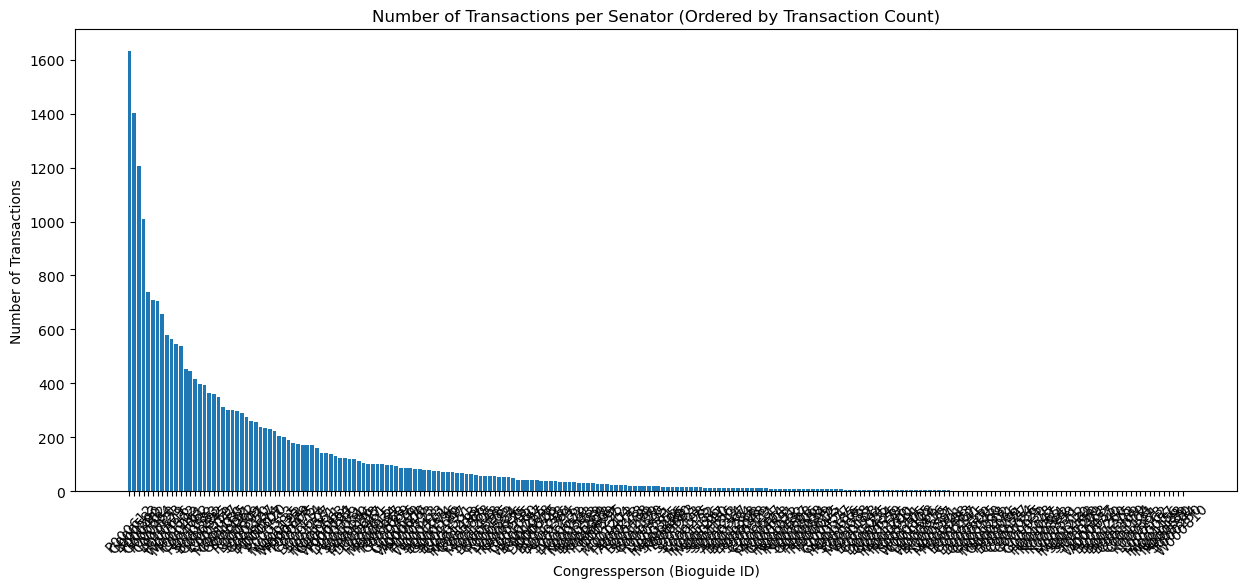

226
[1630, 1403, 1206, 1010, 739, 710, 707, 659, 580, 563, 546, 540, 452, 445, 417, 398, 395, 365, 361, 350, 314, 302, 300, 298, 289, 275, 261, 259, 238, 234, 233, 225, 205, 203, 190, 181, 175, 173, 173, 171, 161, 143, 141, 140, 133, 123, 123, 122, 121, 111, 107, 103, 102, 101, 100, 97, 97, 93, 88, 86, 86, 82, 82, 81, 79, 76, 76, 73, 73, 72, 69, 68, 65, 64, 60, 59, 58, 57, 56, 55, 54, 52, 50, 44, 43, 43, 42, 42, 40, 39, 38, 37, 35, 35, 35, 35, 33, 31, 31, 30, 29, 28, 26, 25, 25, 24, 23, 22, 22, 21, 21, 19, 19, 19, 18, 18, 18, 17, 16, 15, 15, 15, 15, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
transaction_count = defaultdict(int)

for _, row in transc_data.iterrows():
    bioguide_id = row[0]
    transaction_count[bioguide_id] += 1

sorted_transactions = sorted(transaction_count.items(), key=lambda x: x[1], reverse=True)
bioguide_ids = [item[0] for item in sorted_transactions]
transaction_counts = [item[1] for item in sorted_transactions]

plt.figure(figsize=(15, 6))
plt.bar(bioguide_ids, transaction_counts)
plt.xlabel('Congressperson (Bioguide ID)')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Senator (Ordered by Transaction Count)')
plt.xticks(rotation=45)
plt.show()
print(len(bioguide_ids))
print(transaction_counts)

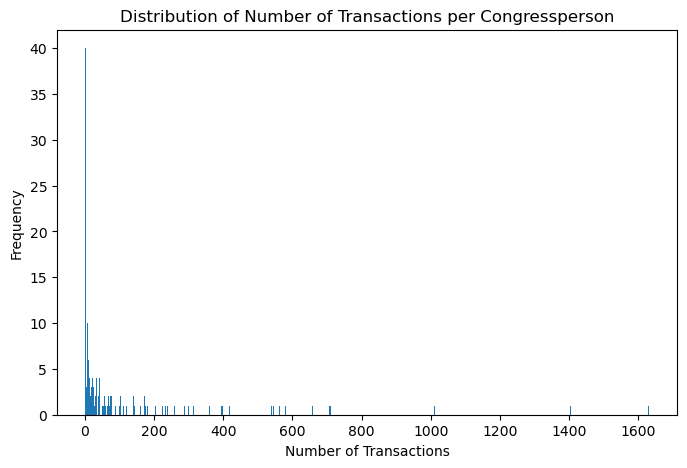

In [ ]:
import matplotlib.pyplot as plt

transaction_count = defaultdict(int)
for _, row in transc_data.iterrows():
    bioguide_id = row[0]
    transaction_count[bioguide_id] += 1

transaction_counts = list(transaction_count.values())

plt.figure(figsize=(8, 5))
plt.hist(transaction_counts, bins=1000)
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Transactions per Congressperson')
plt.show()

23646it [00:21, 1116.03it/s]


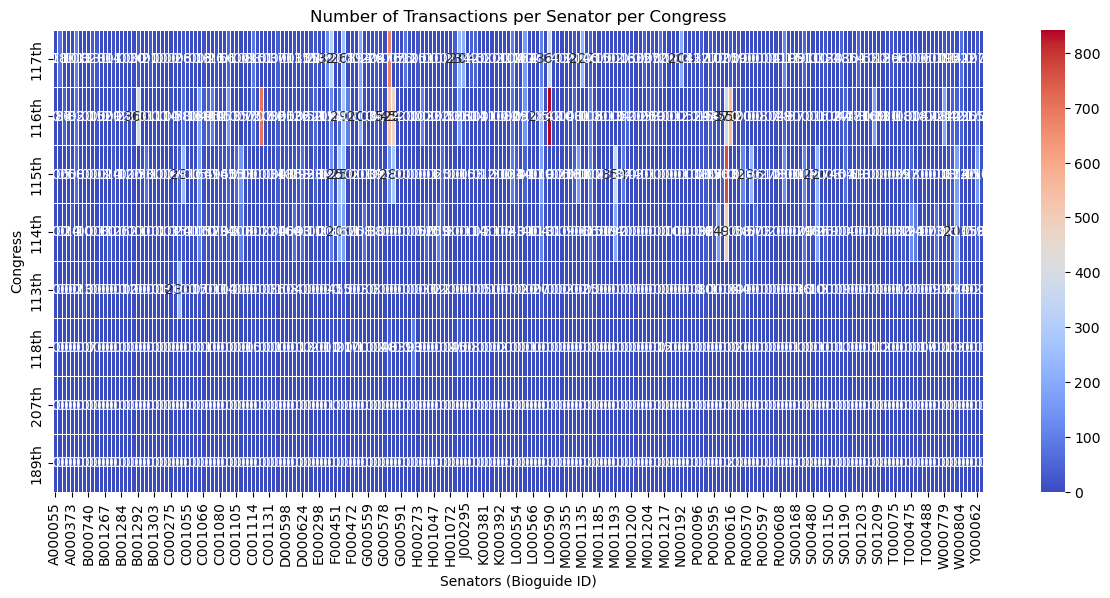

In [ ]:
transaction_count = defaultdict(lambda: defaultdict(int))
from tqdm import tqdm
for _, row in tqdm(transc_data.iterrows()):
    bioguide_id = row[0]
    # print(bioguide_id)
    name = row[1]
    # print(full_name)
    trans_date = row[3]
    congress = get_congress_number(str(trans_date))
    # print(str(trans_date))
    # print(congress)
    transaction_count[bioguide_id][congress] += 1
    transaction_df = pd.DataFrame(transaction_count).fillna(0)

plt.figure(figsize=(15, 6))
sns.heatmap(transaction_df, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.0f')
plt.xlabel('Senators (Bioguide ID)')
plt.ylabel('Congress')
plt.title('Number of Transactions per Senator per Congress')
plt.show()
# print(transaction_count.keys())

In [ ]:
transaction_df = transaction_df.drop(['207th', '189th'], axis=0)
transaction_df

,A000055,A000076,A000364,A000367,A000373,B000574,B000575,B000589,B000740,B001248,...,W000779,W000797,W000800,W000802,W000804,W000805,W000810,W000816,Y000062,Y000063
117th,1.0,78.0,1.0,0.0,0.0,108.0,1.0,0.0,1.0,33.0,...,19.0,11.0,15.0,4.0,72.0,1.0,0.0,0.0,27.0,0.0
116th,0.0,8.0,37.0,6.0,0.0,83.0,2.0,0.0,0.0,0.0,...,184.0,1.0,42.0,42.0,42.0,3.0,1.0,0.0,55.0,0.0
115th,0.0,0.0,0.0,5.0,0.0,68.0,0.0,0.0,0.0,0.0,...,0.0,13.0,31.0,174.0,13.0,2.0,0.0,0.0,157.0,10.0
114th,0.0,0.0,0.0,1.0,24.0,0.0,0.0,10.0,0.0,0.0,...,0.0,16.0,0.0,209.0,11.0,0.0,0.0,5.0,59.0,8.0
113th,0.0,0.0,0.0,0.0,0.0,0.0,1.0,23.0,0.0,0.0,...,0.0,2.0,0.0,134.0,0.0,0.0,0.0,0.0,2.0,0.0
118th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cgp_congress_pairs = []

# Iterate through the rows of transaction_df
for idx, row in transaction_df.iterrows():
    congress_num = int(idx[:-2])  # Extract the congress number as an integer
    # Iterate through the columns (bioguide_id) of the row
    for bioguide_id, value in row.items():
        # Check if the value is greater than or equal to 5
        if value >= 5 and congress_num >= 115:
            cgp_congress_pairs.append((bioguide_id, congress_num))

print(cgp_congress_pairs)
print(len(cgp_congress_pairs))

[('A000076', 117), ('B000574', 117), ('B001248', 117), ('B001255', 117), ('B001274', 117), ('B001292', 117), ('B001299', 117), ('C001047', 117), ('C001055', 117), ('C001066', 117), ('C001068', 117), ('C001078', 117), ('C001101', 117), ('C001114', 117), ('C001120', 117), ('D000399', 117), ('D000617', 117), ('D000624', 117), ('D000628', 117), ('E000296', 117), ('E000298', 117), ('F000187', 117), ('F000450', 117), ('F000462', 117), ('F000472', 117), ('G000545', 117), ('G000563', 117), ('G000583', 117), ('G000588', 117), ('G000591', 117), ('G000596', 117), ('G000597', 117), ('H000273', 117), ('H001079', 117), ('H001082', 117), ('J000020', 117), ('J000305', 117), ('K000375', 117), ('L000397', 117), ('L000559', 117), ('L000579', 117), ('L000590', 117), ('M000934', 117), ('M001135', 117), ('M001180', 117), ('M001186', 117), ('M001199', 117), ('M001200', 117), ('M001203', 117), ('M001205', 117), ('M001213', 117), ('N000192', 117), ('P000048', 117), ('P000197', 117), ('P000593', 117), ('P000595

In [ ]:
transc_data

naics_distribution = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

transc_data.head(10)

for _, row in transc_data.iterrows():
    bioguide_id = row[0]
    trans_date = row[3]
    naics = row[4]
    congress = get_congress_number(str(trans_date))
    for elem in naics:
        if elem != '':
            naics_distribution[bioguide_id][int(congress[:-2])][elem[:2]] += 1

naics_distribution

defaultdict(<function __main__.<lambda>()>,
            {'A000055': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {117: defaultdict(int, {'33': 2})}),
             'A000076': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {117: defaultdict(int,
                                      {'52': 16,
                                       '44': 5,
                                       '45': 11,
                                       '33': 19,
                                       '51': 12,
                                       '48': 3,
                                       '35': 3,
                                       '32': 11,
                                       '21': 7,
                                       '54': 9,
                                       '42': 1,
                                       '56': 5,
                                       '22': 6,
                                       '31': 

  0%|          | 0/226 [00:00<?, ?it/s]

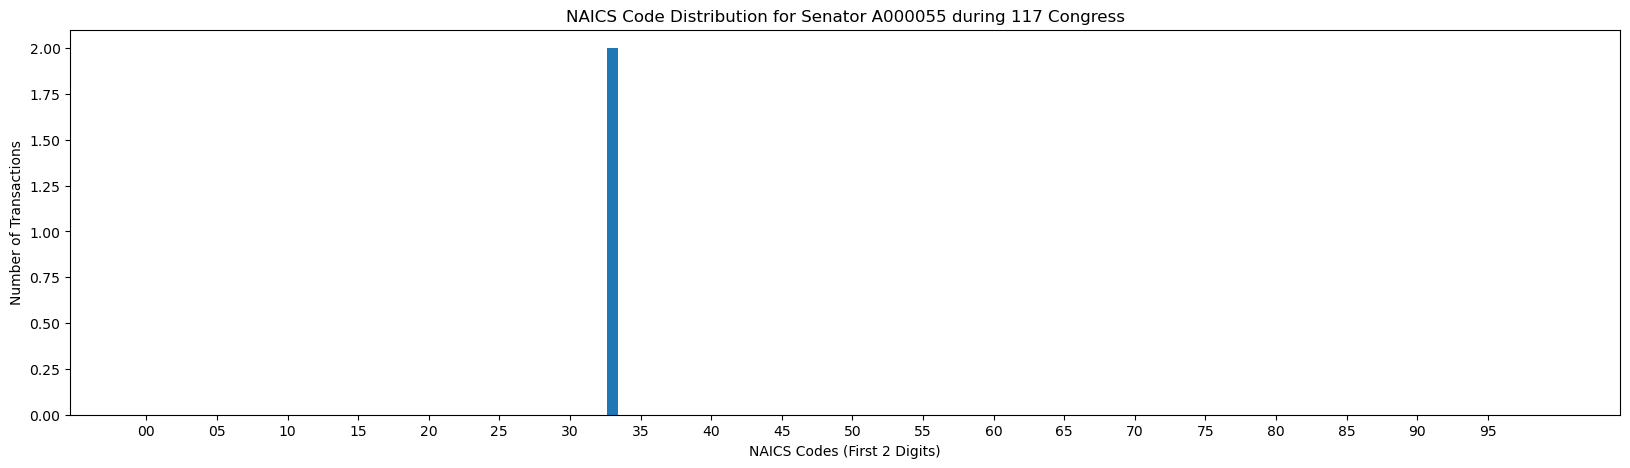

  0%|          | 0/226 [00:00<?, ?it/s]


In [ ]:
def plot_naics_distribution(bioguide_id, congress, naics_count):
    full_naics_count = {str(i).zfill(2): 0 for i in range(100)}
    full_naics_count.update(naics_count)

    naics_codes = sorted(full_naics_count.keys())
    counts = [full_naics_count[naics] for naics in naics_codes]

    plt.figure(figsize=(20, 5))
    plt.bar(naics_codes, counts)
    plt.xticks(range(0, 100, 5))
    plt.xlabel('NAICS Codes (First 2 Digits)')
    plt.ylabel('Number of Transactions')
    plt.title(f'NAICS Code Distribution for Senator {bioguide_id} during {congress} Congress')
    plt.show()

for bioguide_id, congress_transactions in tqdm(naics_distribution.items()):
    for congress, naics_count in congress_transactions.items():
        plot_naics_distribution(bioguide_id, congress, naics_count)
    break

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


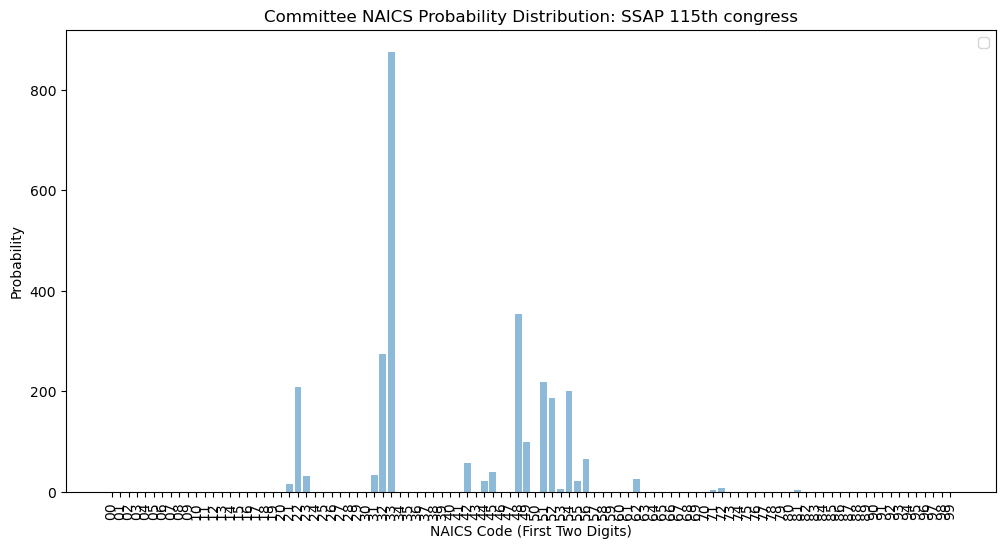

In [ ]:
# Assuming the SQL query output is stored in a DataFrame named 'committee_df'

def get_probability_distribution(naics_count):
    total_transactions = sum(naics_count.values())
    return {naics: count / total_transactions for naics, count in naics_count.items()}

def plot_committee_naics_probability_distribution(committee_naics_prob_dist, selected_congress_num, selected_committee_thomas_id):
    x_labels = [str(i).zfill(2) for i in range(100)]
    y_values = [committee_naics_prob_dist.get(label, 0) for label in x_labels]
    
    x = np.arange(len(x_labels))
    
    plt.figure(figsize=(12, 6))
    plt.bar(x, y_values, align='center', alpha=0.5)
    plt.xticks(x, x_labels, rotation='vertical')
    plt.xlabel('NAICS Code (First Two Digits)')
    plt.ylabel('Probability')
    plt.title(f'Committee NAICS Probability Distribution: {selected_committee_thomas_id} {selected_congress_num}th congress')


import pandas as pd
from collections import defaultdict

committee_naics_dist = defaultdict(int)

selected_congress_num = 115 
selected_committee_thomas_id = "SSAP"

filtered_committee_rows = committee_rows[
    (committee_rows['congress_num'] == selected_congress_num) &
    (committee_rows['committee_thomas_id'] == selected_committee_thomas_id)
]

# Iterate through the rows of the fetched committee_rows
for _, row in filtered_committee_rows.iterrows():
    # print(row)
    naics_array = row[3]
    for naics in naics_array:
        if naics != '':
            committee_naics_dist[naics[:2]] += 1        
# Normalize the counts to create a probability distribution
committee_prob_dist = get_probability_distribution(committee_naics_dist)

# Call the previously defined function to plot the probability distribution
plot_committee_naics_probability_distribution(committee_naics_dist, selected_congress_num, selected_committee_thomas_id)
plt.legend()
plt.show()

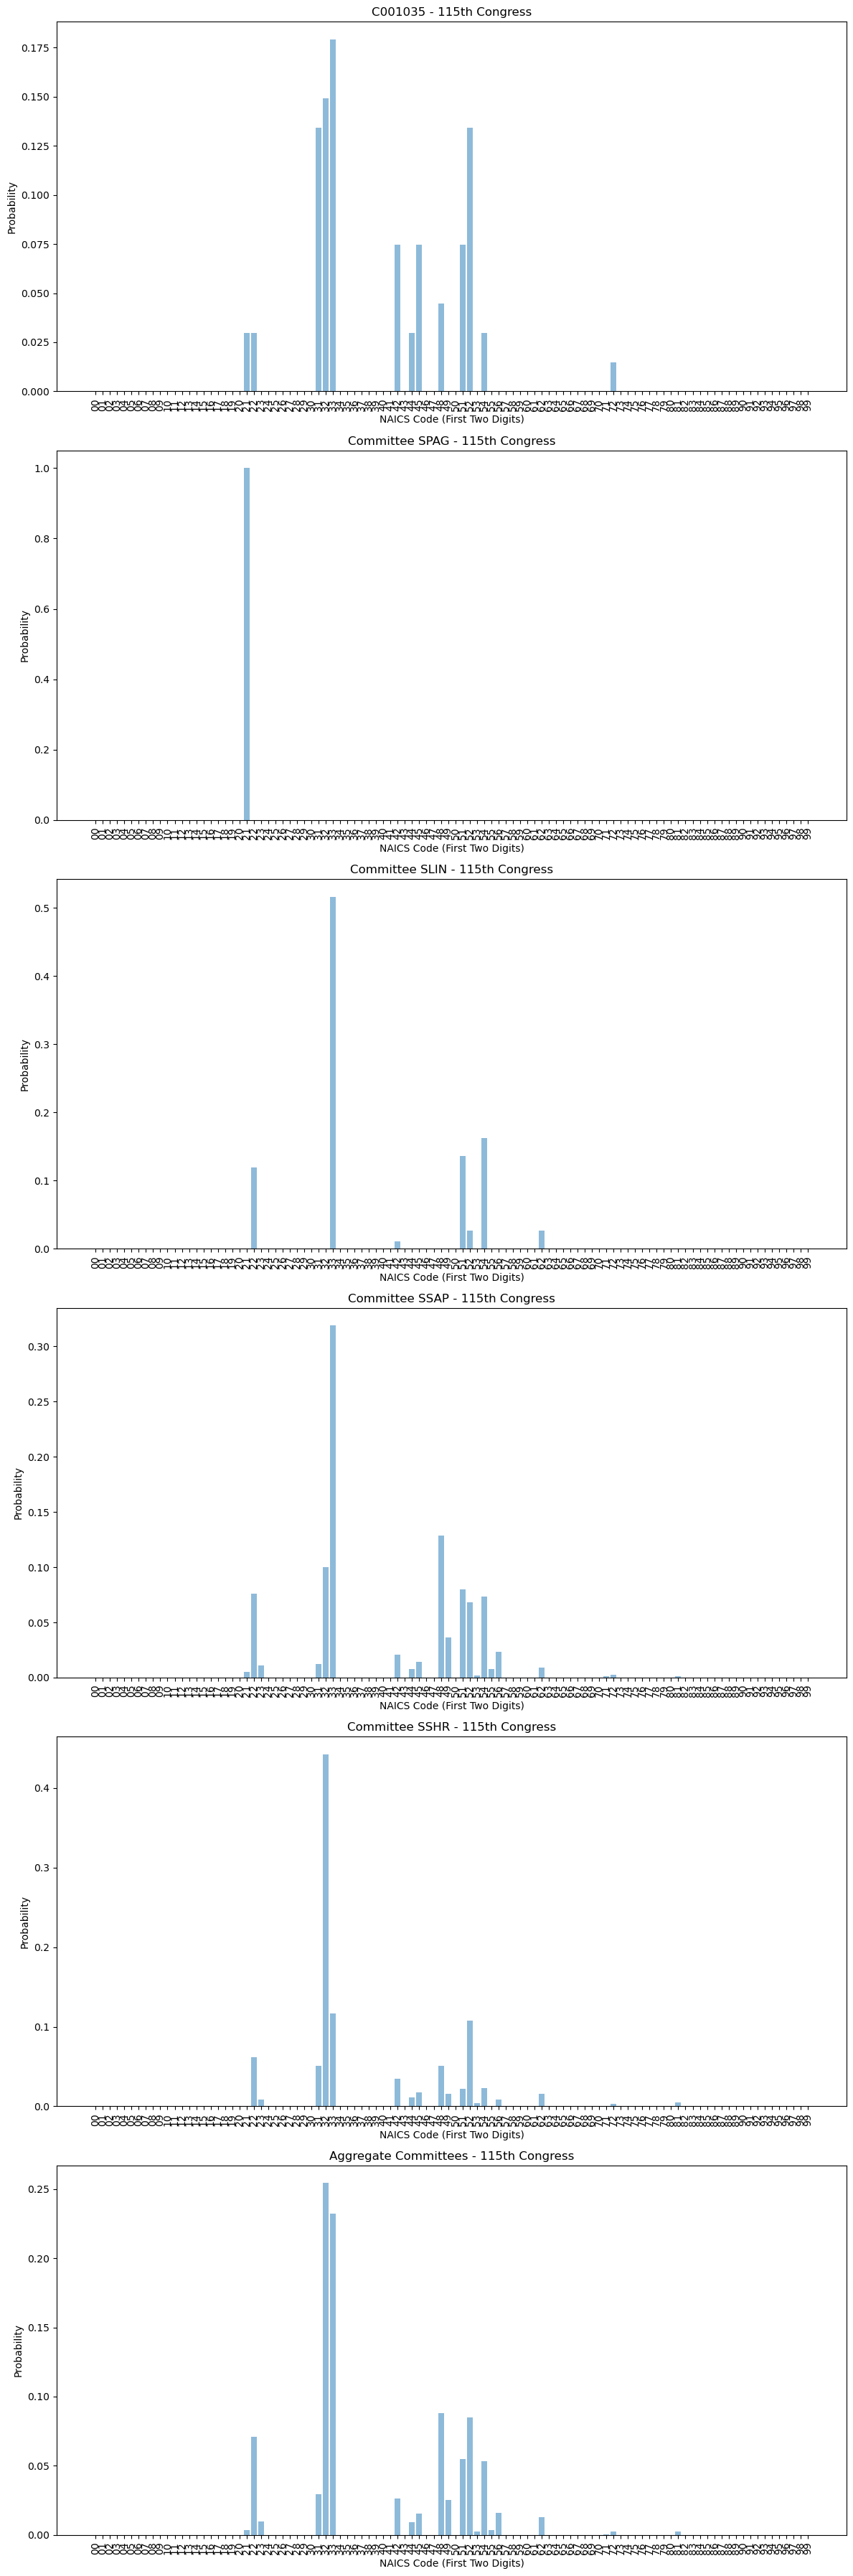

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_committee_naics_dist(committee_id, congress_num):
    committee_naics_dist = defaultdict(int)

    filtered_committee_rows = committee_rows[
    (committee_rows['congress_num'] == congress_num) &
    (committee_rows['committee_thomas_id'] == committee_id)
    ]

    # Iterate through the rows of the fetched committee_rows
    for _, row in filtered_committee_rows.iterrows():
        # print(row)
        naics_array = row[3]
        for naics in naics_array:
            if naics != '':
                committee_naics_dist[naics[:2]] += 1        
            
    return committee_naics_dist

def get_cgp_naics_dist(bioguide_id, congress_num):
    naics_distribution = defaultdict(int)
    filtered_cgp_data = transc_data[transc_data['bioguide_id'] == bioguide_id]

    for _, row in filtered_cgp_data.iterrows():
        bioguide_id = row[0]
        trans_date = row[3]
        naics = row[4]
        congress = get_congress_number(str(trans_date))
        congress = int(congress[:-2])

        # print(congress, congress_num)
        if congress == congress_num:
            for elem in naics:
                # print(elem)
                # print(type(elem))
                # print(congress)
                if elem != '':
                    naics_distribution[elem[:2]] += 1
    # print(naics_distribution)
    return naics_distribution

def get_committees_for_senator_and_congress(bioguide_id, congress_num):

    filtered_committee_assignments = committee_assignments[
    (committee_assignments['congress_num'] == congress_num) &
    (committee_assignments['legislator_bioguide_id'] == bioguide_id)
    ]
    return [row[0] for _, row in filtered_committee_assignments.iterrows()]

def plot_naics_probability_distribution(ax, naics_prob_dist, title):
    x_labels = [str(i).zfill(2) for i in range(100)]
    y_values = [naics_prob_dist.get(label, 0) for label in x_labels]
    
    x = np.arange(len(x_labels))
    
    ax.bar(x, y_values, align='center', alpha=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation='vertical')
    ax.set_xlabel('NAICS Code (First Two Digits)')
    ax.set_ylabel('Probability')
    ax.set_title(title)

def compare_senator_and_committees_naics(bioguide_id, congress_num):
    committees = get_committees_for_senator_and_congress(bioguide_id, congress_num)

    # Get senator's NAICS probability distribution
    cgp_naics_dist = get_cgp_naics_dist(bioguide_id, congress_num)
    cgp_prob_dist = get_probability_distribution(cgp_naics_dist)

    # Create a subplot for each committee, one for the senator, and one for the aggregate committee
    n_plots = len(committees) + 2
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots))

    # Plot senator's NAICS probability distribution
    plot_naics_probability_distribution(axes[0], cgp_prob_dist, f"{bioguide_id} - {congress_num}th Congress")

    # Initialize aggregate committee NAICS distribution
    aggregate_committee_naics_dist = defaultdict(int)

    # Iterate through committees and plot their NAICS probability distribution
    for i, committee_id in enumerate(committees):
        committee_naics_dist = get_committee_naics_dist(committee_id, congress_num)
        committee_prob_dist = get_probability_distribution(committee_naics_dist)

        plot_naics_probability_distribution(axes[i + 1], committee_prob_dist, f"Committee {committee_id} - {congress_num}th Congress")

        # Update aggregate committee NAICS distribution
        for naics, count in committee_naics_dist.items():
            aggregate_committee_naics_dist[naics] += count

    # Plot aggregate committee NAICS probability distribution
    aggregate_committee_prob_dist = get_probability_distribution(aggregate_committee_naics_dist)
    plot_naics_probability_distribution(axes[-1], aggregate_committee_prob_dist, f"Aggregate Committees - {congress_num}th Congress")

    plt.tight_layout()
    plt.show()

# Replace 'senator_bioguide_id' and 'senator_congress_num' with actual values
senator_bioguide_id = "C001035"
senator_congress_num = 115

compare_senator_and_committees_naics(senator_bioguide_id, senator_congress_num)

In [ ]:
print(transaction_df.head(10))

cgp_congress_pairs = []

# Iterate through the rows of transaction_df
for idx, row in transaction_df.iterrows():
    print(row)
    congress_num = int(idx[:-2])  # Extract the congress number as an integer
    # Iterate through the columns (senator_id) of the row
    for bio_id, value in row.items():
        # Check if the value is greater than or equal to 5
        if value >= 5:
            cgp_congress_pairs.append((bio_id, congress_num))

print(cgp_congress_pairs)
print(len(cgp_congress_pairs))

       A000055  A000076  A000364  A000367  A000373  B000574  B000575  B000589   
117th      1.0     78.0      1.0      0.0      0.0    108.0      1.0      0.0  \
116th      0.0      8.0     37.0      6.0      0.0     83.0      2.0      0.0   
115th      0.0      0.0      0.0      5.0      0.0     68.0      0.0      0.0   
114th      0.0      0.0      0.0      1.0     24.0      0.0      0.0     10.0   
113th      0.0      0.0      0.0      0.0      0.0      0.0      1.0     23.0   
118th      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

       B000740  B001248  ...  W000779  W000797  W000800  W000802  W000804   
117th      1.0     33.0  ...     19.0     11.0     15.0      4.0     72.0  \
116th      0.0      0.0  ...    184.0      1.0     42.0     42.0     42.0   
115th      0.0      0.0  ...      0.0     13.0     31.0    174.0     13.0   
114th      0.0      0.0  ...      0.0     16.0      0.0    209.0     11.0   
113th      0.0      0.0  ...      0.0      2.0 

100%|██████████| 339/339 [01:09<00:00,  4.90it/s]


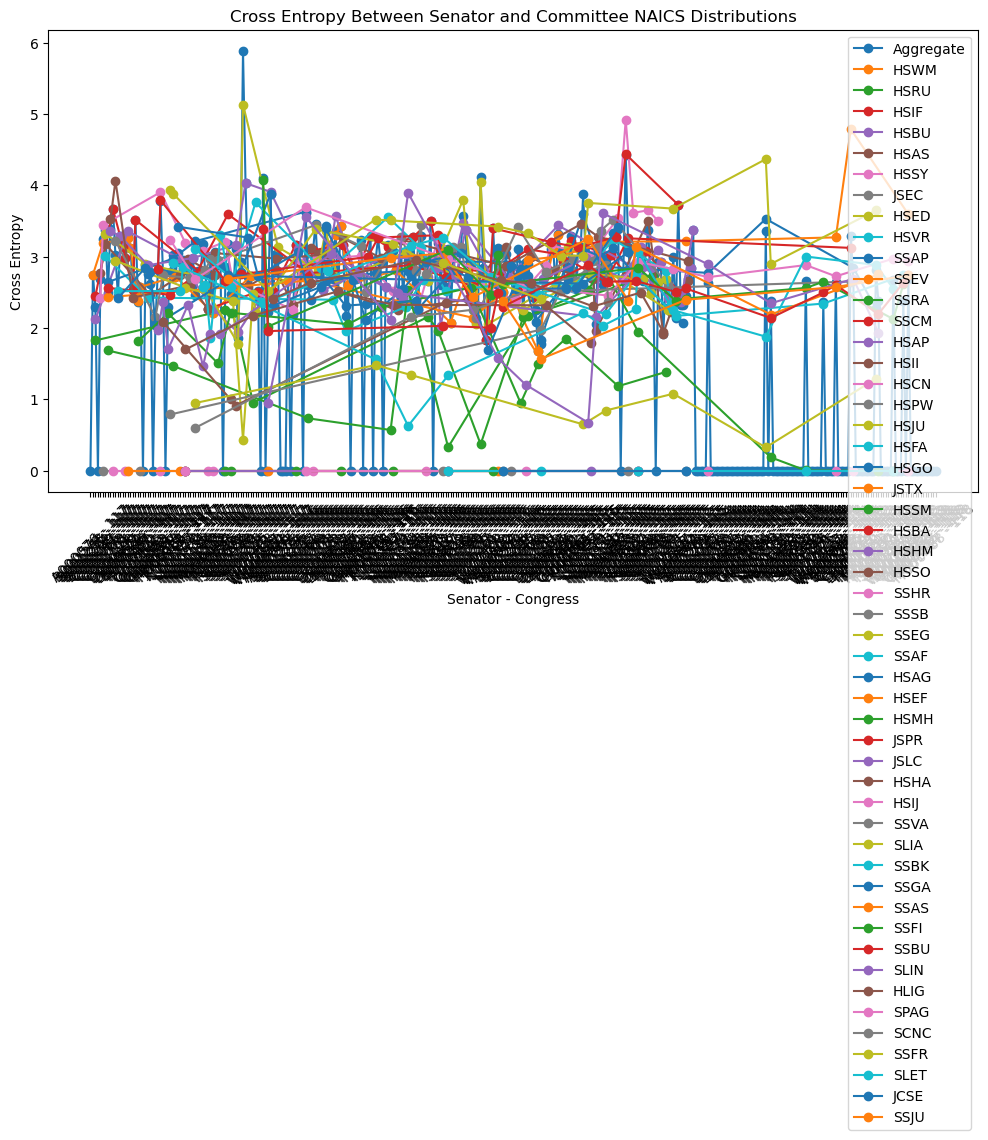

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Calculate cross-entropy between two probability distributions
def cross_entropy(p, q):
    ce = 0
    for key in p:
        if key in q and q[key] > 0:
            ce += p[key] * np.log(q[key])
    return -ce

# Initialize an empty DataFrame to store the cross-entropy values
columns = ["senator", "congress", "committee", "cross_entropy"]
cross_entropy_df = pd.DataFrame(columns=columns)

# Iterate through the senator, congress pairs
for senator, congress in tqdm(cgp_congress_pairs):
    senator_naics_dist = get_cgp_naics_dist(senator, congress)
    senator_prob_dist = get_probability_distribution(senator_naics_dist)

    committees = get_committees_for_senator_and_congress(senator, congress)
    for committee in committees:
        committee_naics_dist = get_committee_naics_dist(committee, congress)
        committee_prob_dist = get_probability_distribution(committee_naics_dist)

        ce = cross_entropy(senator_prob_dist, committee_prob_dist)
        # cross_entropy_df = cross_entropy_df.append({"senator": senator,
        #                                             "congress": congress,
        #                                             "committee": committee,
        #                                             "cross_entropy": ce},
        #                                            ignore_index=True)

        cross_entropy_df = pd.concat([cross_entropy_df, pd.DataFrame({"senator": [senator],
                                                                    "congress": [congress],
                                                                    "committee": [committee],
                                                                    "cross_entropy": [ce]})],
                                                                    ignore_index=True)
    # Calculate cross-entropy with aggregate committee
    aggregate_committee_naics_dist = defaultdict(int)
    for committee in committees:
        committee_naics_dist = get_committee_naics_dist(committee, congress)
        for naics, count in committee_naics_dist.items():
            aggregate_committee_naics_dist[naics] += count
    aggregate_committee_prob_dist = get_probability_distribution(aggregate_committee_naics_dist)

    ce = cross_entropy(senator_prob_dist, aggregate_committee_prob_dist)
    # cross_entropy_df = cross_entropy_df.append({"senator": senator,
    #                                             "congress": congress,
    #                                             "committee": "Aggregate",
    #                                             "cross_entropy": ce},
    #                                            ignore_index=True)

    # Replace cross_entropy_df.append with pd.concat
    cross_entropy_df = pd.concat([cross_entropy_df, pd.DataFrame({"senator": [senator],
                                                              "congress": [congress],
                                                              "committee": ["Aggregate"],
                                                              "cross_entropy": [ce]})],
                                                              ignore_index=True)

# Visualize cross-entropy values in a plot
plt.figure(figsize=(12, 6))
for committee in cross_entropy_df["committee"].unique():
    committee_df = cross_entropy_df[cross_entropy_df["committee"] == committee]
    plt.plot(committee_df["senator"] + " - " + committee_df["congress"].astype(str),
             committee_df["cross_entropy"], label=committee, marker="o")

plt.xlabel("Senator - Congress")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy Between Senator and Committee NAICS Distributions")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
cgp_congress_pairs[23]

('F000462', 117)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.text import Text
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to get the list of committee codes
def get_committee_codes():
    # Replace this list with the actual committee codes
    return ['HSCN', 'SSBU', 'HSGO', 'SSEG', 'HSBU', 'HSEF', 'HSIJ', 'SLIA', 'HLET', 'HSSM', 'HSIF', 'HSMM', 'HSAG', 'HHAH', 'SSAP', 'SSAS', 'HSFA', 'SPOC', 'HSPO', 'HSAP', 'SCNC', 'SPWW', 'SSAE', 'HSVR', 'HSHM', 'HSUA', 'SPIM', 'SSAF', 'HSWM', 'HLCQ', 'HSRU', 'SSVA', 'SSCM', 'SSSB', 'HSAS', 'SSDT', 'HLIG', 'HSSO', 'HSMH', 'HSBA', 'SPAG', 'SSRA', 'SLIN', 'HSGW', 'HSVC', 'HSSY', 'SLET', 'SSFR', 'HSED', 'SSPO', 'SSHR', 'HLOC', 'SSJU', 'HSHA', 'HSAT', 'HSII', 'HSPW', 'SSBK', 'SSGA', 'HSDT', 'SLPO', 'HSJU', 'SSFI', 'SSEV', 'HTDE']


from scipy.stats import entropy

def update_dict(dct):
    for i in range(10, 100):
        key = str(i)
        if key not in dct:
            dct[key] = 1e-10
    return dct

def compute_cross_entropy(p, q):
    p = update_dict(p)
    q = update_dict(q)

    return entropy(list(p.values()), list(q.values()))

committees = get_committee_codes() + ["Aggregate"]

# Initialize an empty DataFrame to store the cross-entropy values
columns = ["senator", "congress", "committee", "cross_entropy"]
cross_entropy_df = pd.DataFrame(columns=columns)

# Iterate through the senator, congress pairs
for senator, congress in tqdm(cgp_congress_pairs):    
    senator_naics_dist = get_cgp_naics_dist(senator, congress)
    senator_prob_dist = get_probability_distribution(senator_naics_dist)

    assigned_committees = get_committees_for_senator_and_congress(senator, congress)

    aggregate_committee_naics_dist = defaultdict(int)
    for committee in committees:
        if committee != "Aggregate":
            committee_naics_dist = get_committee_naics_dist(committee, congress)
            committee_naics_prob_dist = get_probability_distribution(committee_naics_dist)

            for naics, count in committee_naics_dist.items():
                aggregate_committee_naics_dist[naics] += count


        cross_entropy = compute_cross_entropy(senator_prob_dist, committee_naics_prob_dist)
        # cross_entropy_df = cross_entropy_df.append({"senator": senator,
        #                                             "congress": congress,
        #                                             "committee": committee,
        #                                             "cross_entropy": cross_entropy},
        #                                            ignore_index=True)
        
        cross_entropy_df = pd.concat([cross_entropy_df, pd.DataFrame({"senator": [senator],
                                                            "congress": [congress],
                                                            "committee": [committee],
                                                            "cross_entropy": [cross_entropy]})],
                                                            ignore_index=True)


    
    aggregate_committee_prob_dist = get_probability_distribution(aggregate_committee_naics_dist)
    cross_entropy = compute_cross_entropy(senator_prob_dist, aggregate_committee_prob_dist)

    if len(assigned_committees) == 0:
        cross_entropy= np.inf

    # cross_entropy_df = cross_entropy_df.append({"senator": senator,
    #                                                 "congress": congress,
    #                                                 "committee": "Aggregate",
    #                                                 "cross_entropy": cross_entropy},
    #                                                ignore_index=True)

    cross_entropy_df = pd.concat([cross_entropy_df, pd.DataFrame({"senator": [senator],
                                                            "congress": [congress],
                                                            "committee": ["Aggregate"],
                                                            "cross_entropy": [cross_entropy]})],
                                                            ignore_index=True)

    # break

# Pivot the DataFrame to create a matrix with senators, congress numbers, and committees
pivot_df = cross_entropy_df.pivot_table(values="cross_entropy",
                                        index=["senator", "congress"],
                                        columns="committee",
                                        fill_value=0)



100%|██████████| 339/339 [16:02<00:00,  2.84s/it]
/Users/syyun/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:383: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


In [ ]:
pivot_df
pivot_df.replace([np.inf, -np.inf], np.nan, inplace=True)
pivot_df
# pivot_df.mean()

committee         Aggregate      HHAH      HLCQ      HLET      HLIG      HLOC   
senator congress                                                                
A000076 116             NaN  2.838487  2.838487  2.838487  0.761769  2.838487  \
        117             NaN  1.994510  1.994510  1.994510  0.521573  1.994510   
A000364 116             NaN  2.080461  2.080461  2.080461  0.945896  2.080461   
A000367 115        1.770435  2.526808  2.526808  2.526808  0.851615  2.526808   
        116             NaN  2.492253  2.492253  2.492253  0.713247  2.492253   
...                     ...       ...       ...       ...       ...       ...   
Y000062 115        1.533839  1.911668  1.911668  1.911668  3.613613  1.911668   
        116        1.266737  2.034654  2.034654  2.034654  0.744543  2.034654   
        117        1.448163  2.189661  2.189661  2.189661  0.939949  2.189661   
Y000063 114             NaN  3.268878  3.268878  3.268878  1.074649  3.268878   
        115        2.367116  3.016054  3.016054  3.016054  2.254583  3.016054   

committee             HSAG      HSAP      HSAS      HSAT  ...      SSEV   
senator congress                                          ...             
A000076 116       1.124205  0.843289  2.437729  2.838487  ...  0.700261  \
        117       1.040841  0.628032  0.404431  1.994510  ...  0.908134   
A000364 116       0.574210  0.743707  1.839397  2.080461  ...  0.655662   
A000367 115       0.833049  0.838817  1.323293  2.526808  ...  0.826874   
        116       1.049994  1.174849  1.539766  2.492253  ...  0.449228   
...                    ...       ...       ...       ...  ...       ...   
Y000062 115       1.192816  1.089261  1.562192  1.911668  ...  1.800988   
        116       1.327433  0.337460  1.402903  2.034654  ...  0.524634   
        117       1.443406  0.917788  0.708776  2.189661  ...  1.017068   
Y000063 114       0.709191  1.115307  3.373584  3.268878  ...  1.434535   
        115       1.325228  0.965332  0.983607  3.016054  ...  1.925699   

committee             SSFI      SSFR      SSGA      SSHR      SSJU      SSPO   
senator congress                                                               
A000076 116       0.747220  1.010105  0.925417  0.464875  0.679325  2.838487  \
        117       0.932682  4.017124  0.546993  0.573883  0.662098  1.994510   
A000364 116       0.175522  1.021154  0.591030  0.530559  0.666639  2.080461   
A000367 115       0.901126  0.785693  0.825169  1.040361  1.000287  2.526808   
        116       0.865982  1.315268  0.817794  0.740687  0.897260  2.492253   
...                    ...       ...       ...       ...       ...       ...   
Y000062 115       0.887576  1.149926  1.091550  0.980916  1.091251  1.911668   
        116       0.511955  0.743672  0.495603  0.515490  0.819876  2.034654   
        117       1.201255  3.937793  0.431914  1.087356  0.959601  2.189661   
Y000063 114       1.133967  0.576989  1.290782  1.280473  0.882297  3.268878   
        115       1.236722  0.956680  1.074659  0.813844  2.818082  3.016054   

committee              SSRA      SSSB      SSVA  
senator congress                                 
A000076 116        6.641782  0.735877  1.161677  
        117        9.210612  6.179240  8.430289  
A000364 116       10.927072  0.299179  3.226855  
A000367 115        0.291676  0.664019  1.056676  
        116       13.373932  0.652843  0.785270  
...                     ...       ...       ...  
Y000062 115        5.757342  3.014428  4.008703  
        116       10.448575  0.210645  4.889986  
        117        7.718390  4.867120  5.925283  
Y000063 114        9.668030  1.357093  0.940208  
        115        1.285354  1.599377  0.838250  

[339 rows x 66 columns]

In [ ]:
# pickle pivot_df
# import pickle
# with open('pivot_df.pickle', 'wb') as handle:
#     pickle.dump(pivot_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# import pickle df
import pickle
with open('pivot_df.pickle', 'rb') as handle:
    pivot_df = pickle.load(handle)

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

A000076 116 []


/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/var/folders/d7/661_pryx1zx9ctp4z8417_d80000gn/T/ipykernel_36287/913117441.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


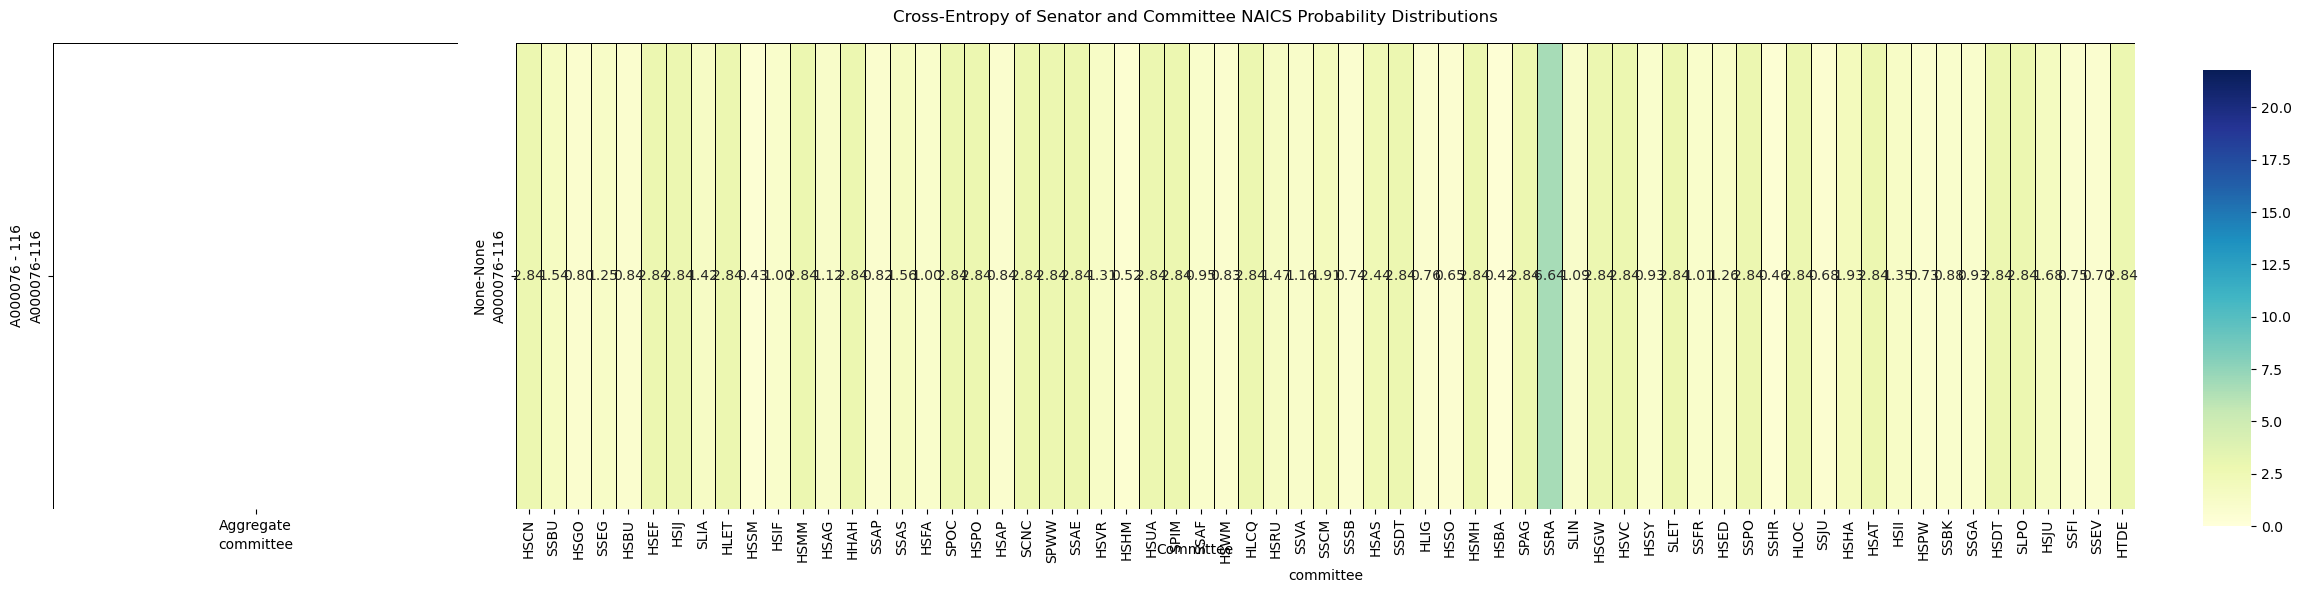

In [29]:
from matplotlib.colors import Normalize

# Find the min and max values for normalization
vmin = pivot_df.min().min()
vmax = pivot_df.max().max()
norm = Normalize(vmin=vmin, vmax=vmax)

for i, (index, row) in enumerate(pivot_df.iterrows()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 4]})
    cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
    
    senator, congress = index[0], index[1]
    assigned_committees = get_committees_for_senator_and_congress(senator, congress)
    assigned_committees = [committee for committee in assigned_committees if committee.startswith("S")]
    print(senator, congress, assigned_committees)



    assigned_committees.append("Aggregate")

    sns.heatmap(row[assigned_committees].to_frame().T,
                cmap="YlGnBu", linewidths=0.5, linecolor="black", annot=True, fmt=".2f", ax=ax1, cbar=False, norm=norm)

    sns.heatmap(row[[committee for committee in committees if committee not in assigned_committees]].to_frame().T,
                cmap="YlGnBu", linewidths=0.5, linecolor="black", annot=True, fmt=".2f", ax=ax2, cbar_ax=cbar_ax, norm=norm)

    ax1.set_ylabel(f"{senator} - {congress}")

    for label in ax1.get_xticklabels():
        label.set_text(f"{label.get_text()}")

    fig.text(0.5, 0.08, "Committee", ha='center', va='center')
    fig.suptitle("Cross-Entropy of Senator and Committee NAICS Probability Distributions")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()
    plt.close(fig)
    break

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

assigned_ce = []
unassigned_ce = []

for _, (index, row) in enumerate(pivot_df.iterrows()):
    senator, congress = index[0], index[1]
    assigned_committees = get_committees_for_senator_and_congress(senator, congress)
    if len(assigned_committees) == 0:
        continue

    for committee in row.index:
        if committee == "Aggregate":
            continue

        ce_value = row[committee]
        if np.isnan(ce_value):
            continue

        if committee in assigned_committees:
            assigned_ce.append(ce_value)
        else:
            unassigned_ce.append(ce_value)



t_stat, p_value = ttest_ind(assigned_ce, unassigned_ce, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.9f}")

alpha = 0.05
if p_value < alpha:
    print("The means of cross-entropy values for assigned and unassigned committees are significantly different.")
else:
    print("There is no significant difference between the means of cross-entropy values for assigned and unassigned committees.")

T-statistic: -6.2662
P-value: 0.000000001
The means of cross-entropy values for assigned and unassigned committees are significantly different.


In [ ]:
# import numpy as np

# mean1 = np.mean(assigned_ce)
# mean2 = np.mean(unassigned_ce)
# sd1 = np.std(assigned_ce, ddof=1)  # ddof=1 for sample standard deviation
# sd2 = np.std(unassigned_ce, ddof=1)
# n1 = len(assigned_ce)
# n2 = len(unassigned_ce)

# pooled_sd = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
# cohens_d = (mean1 - mean2) / pooled_sd

# print(f"Cohen's d: {cohens_d:.4f}")

Cohen's d: -0.2757


In [ ]:
# import numpy as np

# mean1 = np.mean(assigned_ce)
# mean2 = np.mean(unassigned_ce)
# sd1 = np.std(assigned_ce, ddof=1)  # ddof=1 for sample standard deviation
# sd2 = np.std(unassigned_ce, ddof=1)
# n1 = len(assigned_ce)
# n2 = len(unassigned_ce)

# pooled_sd = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
# correction_factor = 1 - 3 / (4 * (n1 + n2) - 9)
# hedges_g = (mean1 - mean2) / pooled_sd * correction_factor

# print(f"Hedges' g: {hedges_g:.4f}")

Hedges' g: -0.2757


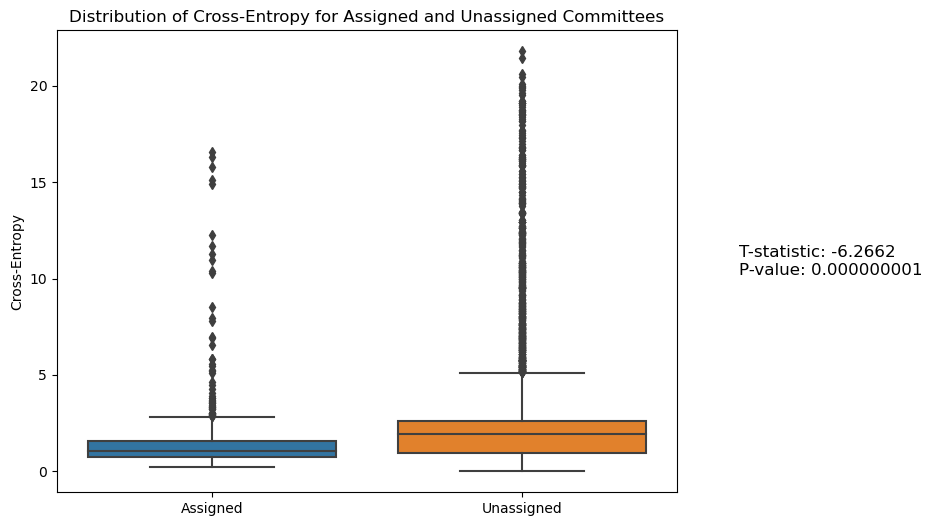

572 14703


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[assigned_ce, unassigned_ce], notch=False)
plt.xticks([0, 1], ['Assigned', 'Unassigned'])
plt.ylabel('Cross-Entropy')
plt.title('Distribution of Cross-Entropy for Assigned and Unassigned Committees')

# Display the t-test result on the plot
result_text = f"T-statistic: {t_stat:.4f}\nP-value: {p_value:.9f}"
plt.text(
    1.1,
    0.5,
    result_text,
    fontsize=12,
    verticalalignment='center',
    transform=plt.gca().transAxes,
)

# Show the plot
plt.show()
print(len(assigned_ce), len(unassigned_ce))


In [ ]:
print(len(assigned_ce))

572


In [ ]:
print(len(unassigned_ce))

14703


In [ ]:
pivot_df.index
pivot_df['SSFI']

senator  congress
A000076  116         0.747220
         117         0.932682
A000364  116         0.175522
A000367  115         0.901126
         116         0.865982
                       ...   
Y000062  115         0.887576
         116         0.511955
         117         1.201255
Y000063  114         1.133967
         115         1.236722
Name: SSFI, Length: 339, dtype: float64

In [ ]:
df = pivot_df.copy()
cmm = 'SSFI'

for bio, cgn in pivot_df.index:
    cmms = get_committees_for_senator_and_congress(bio, cgn)
    if cmm in cmms:
        df.loc[(bio, cgn), 'AssignedToCommittee'] = 1
    else:
        df.loc[(bio, cgn), 'AssignedToCommittee'] = 0

for bio, cgn in pivot_df.index:
    lagged_cgn = cgn - 1
    cmms = get_committees_for_senator_and_congress(bio, lagged_cgn)
    if cmm in cmms:
        df.loc[(bio, cgn), 'LaggedCommitteeAssignments'] = 1
    else:
        df.loc[(bio, cgn), 'LaggedCommitteeAssignments'] = 0



In [ ]:
import pandas as pd
from linearmodels import PanelOLS
from linearmodels.panel import PooledOLS
from linearmodels.panel.data import PanelData

# Define the dependent variable (y) and the independent variables (X)
y = cmm  # Replace this with the actual column name for the dependent variable
X = ['AssignedToCommittee', 'LaggedCommitteeAssignments']

# Fit the fixed effects model
model = PanelOLS(df[cmm], df[X], entity_effects=True, time_effects=True)
results = model.fit()

# Print the summary of the regression model
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   SSFI   R-squared:                        0.0109
Estimator:                   PanelOLS   R-squared (Between):             -0.0068
No. Observations:                 339   R-squared (Within):               0.0061
Date:                Fri, Mar 31 2023   R-squared (Overall):             -0.0117
Time:                        11:31:41   Log-likelihood                    26.416
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.9216
Entities:                         164   P-value                           0.3999
Avg Obs:                       2.0671   Distribution:                   F(2,168)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             0.9216
                            

In [ ]:
df

committee         Aggregate      HHAH      HLCQ      HLET      HLIG      HLOC  \
senator congress                                                                
A000076 116             NaN  2.838487  2.838487  2.838487  0.761769  2.838487   
        117             NaN  1.994510  1.994510  1.994510  0.521573  1.994510   
A000364 116             NaN  2.080461  2.080461  2.080461  0.945896  2.080461   
A000367 115        1.770435  2.526808  2.526808  2.526808  0.851615  2.526808   
        116             NaN  2.492253  2.492253  2.492253  0.713247  2.492253   
...                     ...       ...       ...       ...       ...       ...   
Y000062 115        1.533839  1.911668  1.911668  1.911668  3.613613  1.911668   
        116        1.266737  2.034654  2.034654  2.034654  0.744543  2.034654   
        117        1.448163  2.189661  2.189661  2.189661  0.939949  2.189661   
Y000063 114             NaN  3.268878  3.268878  3.268878  1.074649  3.268878   
        115        2.367116  3.016054  3.016054  3.016054  2.254583  3.016054   

committee             HSAG      HSAP      HSAS      HSAT  ...      SSFR  \
senator congress                                          ...             
A000076 116       1.124205  0.843289  2.437729  2.838487  ...  1.010105   
        117       1.040841  0.628032  0.404431  1.994510  ...  4.017124   
A000364 116       0.574210  0.743707  1.839397  2.080461  ...  1.021154   
A000367 115       0.833049  0.838817  1.323293  2.526808  ...  0.785693   
        116       1.049994  1.174849  1.539766  2.492253  ...  1.315268   
...                    ...       ...       ...       ...  ...       ...   
Y000062 115       1.192816  1.089261  1.562192  1.911668  ...  1.149926   
        116       1.327433  0.337460  1.402903  2.034654  ...  0.743672   
        117       1.443406  0.917788  0.708776  2.189661  ...  3.937793   
Y000063 114       0.709191  1.115307  3.373584  3.268878  ...  0.576989   
        115       1.325228  0.965332  0.983607  3.016054  ...  0.956680   

committee             SSGA      SSHR      SSJU      SSPO       SSRA      SSSB  \
senator congress                                                                
A000076 116       0.925417  0.464875  0.679325  2.838487   6.641782  0.735877   
        117       0.546993  0.573883  0.662098  1.994510   9.210612  6.179240   
A000364 116       0.591030  0.530559  0.666639  2.080461  10.927072  0.299179   
A000367 115       0.825169  1.040361  1.000287  2.526808   0.291676  0.664019   
        116       0.817794  0.740687  0.897260  2.492253  13.373932  0.652843   
...                    ...       ...       ...       ...        ...       ...   
Y000062 115       1.091550  0.980916  1.091251  1.911668   5.757342  3.014428   
        116       0.495603  0.515490  0.819876  2.034654  10.448575  0.210645   
        117       0.431914  1.087356  0.959601  2.189661   7.718390  4.867120   
Y000063 114       1.290782  1.280473  0.882297  3.268878   9.668030  1.357093   
        115       1.074659  0.813844  2.818082  3.016054   1.285354  1.599377   

committee             SSVA  AssignedToCommittee  LaggedCommitteeAssignments  
senator congress                                                             
A000076 116       1.161677                  0.0                         0.0  
        117       8.430289                  0.0                         0.0  
A000364 116       3.226855                  0.0                         0.0  
A000367 115       1.056676                  0.0                         0.0  
        116       0.785270                  0.0                         0.0  
...                    ...                  ...                         ...  
Y000062 115       4.008703                  0.0                         0.0  
        116       4.889986                  0.0                         0.0  
        117       5.925283                  0.0                         0.0  
Y000063 114       0.940208                  0.0           

In [ ]:
import pandas as pd
from linearmodels import PanelOLS
from linearmodels.panel.data import PanelData

def fit_panel_ols_for_committee(df, committee_code):
    # Preprocess the DataFrame for the given committee code
    try:
        df = df.copy()
        
        for bio, cgn in df.index:
            cmms = get_committees_for_senator_and_congress(bio, cgn)
            
            if committee_code in cmms:
                df.loc[(bio, cgn), f'AssignedTo{committee_code}'] = 1
            else:
                df.loc[(bio, cgn), f'AssignedTo{committee_code}'] = 0

            # lagged_cgn = cgn - 1
            # cmms = get_committees_for_senator_and_congress(bio, lagged_cgn)
            # if committee_code in cmms:
            #     df.loc[(bio, cgn), f'Lagged{committee_code}Assignments'] = 1
            # else:
            #     df.loc[(bio, cgn), f'Lagged{committee_code}Assignments'] = 0

        # remove the rows with no committee assignments for lagged period
        # df = df[df.apply(lambda row: len(get_committees_for_senator_and_congress(row.name[0], row.name[1]-1)) > 0, axis=1)]

        # Define the dependent variable (y) and the independent variables (X)
        y = committee_code
        X = [f'AssignedTo{committee_code}'] #, f'Lagged{committee_code}Assignments']

        # Fit the fixed effects model
        model = PanelOLS(df[y], df[X], entity_effects=True, time_effects=True)
        results = model.fit()
    
        return results
    except Exception as e:
        # print(f"Error for committee {committee_code}: {e}")
        return None

# Get the list of committee codes
committee_codes = get_committee_codes()

# Fit the PanelOLS model for all committees
results = {committee_code: fit_panel_ols_for_committee(pivot_df, committee_code) for committee_code in committee_codes}


In [ ]:
import matplotlib.pyplot as plt

coefficients = {
    'committee': [],
    'assigned_coeff': [],
    # 'lagged_coeff': [],
    'assigned_pvalue': [],
    # 'lagged_pvalue': []
}

for committee, result in results.items():
    if result is not None:
        coefficients['committee'].append(committee)
        coefficients['assigned_coeff'].append(result.params[f'AssignedTo{committee}'])
        # coefficients['lagged_coeff'].append(result.params[f'Lagged{committee}Assignments'])
        coefficients['assigned_pvalue'].append(result.pvalues[f'AssignedTo{committee}'])
        # coefficients['lagged_pvalue'].append(result.pvalues[f'Lagged{committee}Assignments'])

coefficients_df = pd.DataFrame(coefficients)

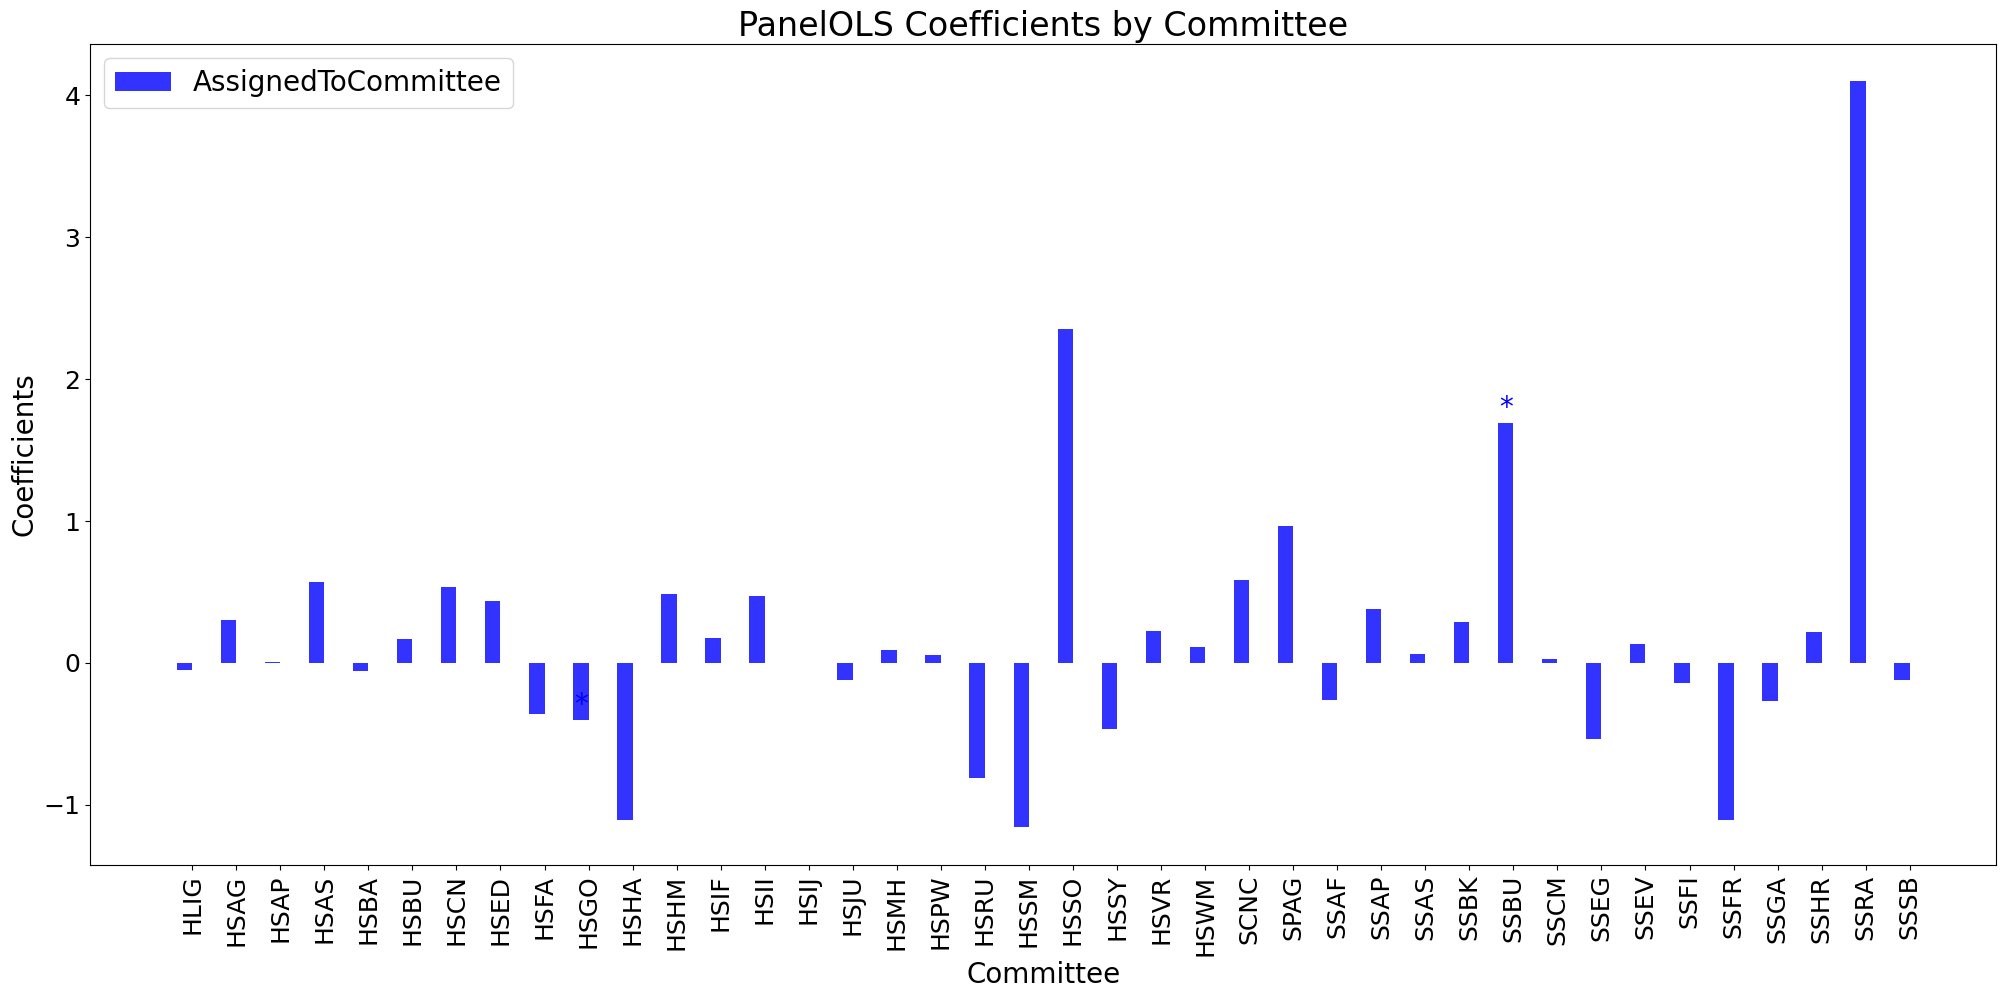

In [ ]:
coefficients_df = coefficients_df.sort_values(by='committee').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 10))

bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(coefficients_df.index, coefficients_df['assigned_coeff'], bar_width,
                 alpha=opacity, color='b', label='AssignedToCommittee')

# rects2 = plt.bar(coefficients_df.index + bar_width, coefficients_df['lagged_coeff'], bar_width,
#                  alpha=opacity, color='g', label='LaggedCommitteeAssignments')

plt.xlabel('Committee', fontsize=20)
plt.ylabel('Coefficients', fontsize=20)
plt.title('PanelOLS Coefficients by Committee', fontsize=24)
plt.xticks(coefficients_df.index, coefficients_df['committee'], rotation=90, fontsize=16)
ax.set_xticks(coefficients_df.index + bar_width / 2)
ax.set_xticklabels(coefficients_df['committee'], fontsize=16)
plt.legend(fontsize=20)
plt.tight_layout()

ax.tick_params(axis='both', which='major', labelsize=18)

for i, row in coefficients_df.iterrows():
    if row['assigned_pvalue'] < 0.05:
        ax.text(i, row['assigned_coeff'] + 0.01, '*', ha='center', va='bottom', fontsize=20, color='b')
    # if row['lagged_pvalue'] < 0.05:
    #     ax.text(i + bar_width, row['lagged_coeff'] + 0.01, '*', ha='center', va='bottom', fontsize=20, color='g')

plt.show()


In [ ]:
df.columns

Index(['Aggregate', 'HHAH', 'HLCQ', 'HLET', 'HLIG', 'HLOC', 'HSAG', 'HSAP',
       'HSAS', 'HSAT', 'HSBA', 'HSBU', 'HSCN', 'HSDT', 'HSED', 'HSEF', 'HSFA',
       'HSGO', 'HSGW', 'HSHA', 'HSHM', 'HSIF', 'HSII', 'HSIJ', 'HSJU', 'HSMH',
       'HSMM', 'HSPO', 'HSPW', 'HSRU', 'HSSM', 'HSSO', 'HSSY', 'HSUA', 'HSVC',
       'HSVR', 'HSWM', 'HTDE', 'SCNC', 'SLET', 'SLIA', 'SLIN', 'SLPO', 'SPAG',
       'SPIM', 'SPOC', 'SPWW', 'SSAE', 'SSAF', 'SSAP', 'SSAS', 'SSBK', 'SSBU',
       'SSCM', 'SSDT', 'SSEG', 'SSEV', 'SSFI', 'SSFR', 'SSGA', 'SSHR', 'SSJU',
       'SSPO', 'SSRA', 'SSSB', 'SSVA', 'AssignedToCommittee',
       'LaggedCommitteeAssignments'],
      dtype='object', name='committee')

In [ ]:
df.index

MultiIndex([('A000076', 116),
            ('A000076', 117),
            ('A000364', 116),
            ('A000367', 115),
            ('A000367', 116),
            ('A000373', 114),
            ('B000574', 115),
            ('B000574', 116),
            ('B000574', 117),
            ('B000589', 113),
            ...
            ('W000804', 115),
            ('W000804', 116),
            ('W000804', 117),
            ('W000816', 114),
            ('Y000062', 114),
            ('Y000062', 115),
            ('Y000062', 116),
            ('Y000062', 117),
            ('Y000063', 114),
            ('Y000063', 115)],
           names=['senator', 'congress'], length=339)

In [ ]:
pivot_df

committee         Aggregate      HHAH      HLCQ      HLET      HLIG      HLOC  \
senator congress                                                                
A000076 116             NaN  2.838487  2.838487  2.838487  0.761769  2.838487   
        117             NaN  1.994510  1.994510  1.994510  0.521573  1.994510   
A000364 116             NaN  2.080461  2.080461  2.080461  0.945896  2.080461   
A000367 115        1.770435  2.526808  2.526808  2.526808  0.851615  2.526808   
        116             NaN  2.492253  2.492253  2.492253  0.713247  2.492253   
...                     ...       ...       ...       ...       ...       ...   
Y000062 115        1.533839  1.911668  1.911668  1.911668  3.613613  1.911668   
        116        1.266737  2.034654  2.034654  2.034654  0.744543  2.034654   
        117        1.448163  2.189661  2.189661  2.189661  0.939949  2.189661   
Y000063 114             NaN  3.268878  3.268878  3.268878  1.074649  3.268878   
        115        2.367116  3.016054  3.016054  3.016054  2.254583  3.016054   

committee             HSAG      HSAP      HSAS      HSAT  ...      SSEV  \
senator congress                                          ...             
A000076 116       1.124205  0.843289  2.437729  2.838487  ...  0.700261   
        117       1.040841  0.628032  0.404431  1.994510  ...  0.908134   
A000364 116       0.574210  0.743707  1.839397  2.080461  ...  0.655662   
A000367 115       0.833049  0.838817  1.323293  2.526808  ...  0.826874   
        116       1.049994  1.174849  1.539766  2.492253  ...  0.449228   
...                    ...       ...       ...       ...  ...       ...   
Y000062 115       1.192816  1.089261  1.562192  1.911668  ...  1.800988   
        116       1.327433  0.337460  1.402903  2.034654  ...  0.524634   
        117       1.443406  0.917788  0.708776  2.189661  ...  1.017068   
Y000063 114       0.709191  1.115307  3.373584  3.268878  ...  1.434535   
        115       1.325228  0.965332  0.983607  3.016054  ...  1.925699   

committee             SSFI      SSFR      SSGA      SSHR      SSJU      SSPO  \
senator congress                                                               
A000076 116       0.747220  1.010105  0.925417  0.464875  0.679325  2.838487   
        117       0.932682  4.017124  0.546993  0.573883  0.662098  1.994510   
A000364 116       0.175522  1.021154  0.591030  0.530559  0.666639  2.080461   
A000367 115       0.901126  0.785693  0.825169  1.040361  1.000287  2.526808   
        116       0.865982  1.315268  0.817794  0.740687  0.897260  2.492253   
...                    ...       ...       ...       ...       ...       ...   
Y000062 115       0.887576  1.149926  1.091550  0.980916  1.091251  1.911668   
        116       0.511955  0.743672  0.495603  0.515490  0.819876  2.034654   
        117       1.201255  3.937793  0.431914  1.087356  0.959601  2.189661   
Y000063 114       1.133967  0.576989  1.290782  1.280473  0.882297  3.268878   
        115       1.236722  0.956680  1.074659  0.813844  2.818082  3.016054   

committee              SSRA      SSSB      SSVA  
senator congress                                 
A000076 116        6.641782  0.735877  1.161677  
        117        9.210612  6.179240  8.430289  
A000364 116       10.927072  0.299179  3.226855  
A000367 115        0.291676  0.664019  1.056676  
        116       13.373932  0.652843  0.785270  
...                     ...       ...       ...  
Y000062 115        5.757342  3.014428  4.008703  
        116       10.448575  0.210645  4.889986  
        117        7.718390  4.867120  5.925283  
Y000063 114        9.668030  1.357093  0.940208  
        115        1.285354  1.599377  0.838250  

[339 rows x 66 columns]

In [ ]:
committee_assignments

,bill_id,client_name,ticker,naics,clientship_id,committee_thomas_id,filing_uuid,congress_num
0,hconres101-112,HARTFORD FINANCIAL SERVICES GROUP,HIG,"[524113, 524126]",123220,HSWM,07ddcb09-0cdb-4791-9eac-0cb6a4f92993,112
1,hconres101-112,HARTFORD FINANCIAL SERVICES GROUP,HIG,"[524113, 524126]",123220,HSWM,19d40580-c957-446f-8582-0f23ae595ad3,112
2,hconres101-112,HARTFORD FINANCIAL SERVICES GROUP,HIG,"[524113, 524126]",123220,HSWM,8546135e-e68b-48e1-b6a1-f44a904b9af9,112
3,hconres101-112,HARTFORD FINANCIAL SERVICES GROUP,HIG,"[524113, 524126]",123220,HSWM,8c98a3d2-d978-4667-957f-052abf5339d6,112
4,hconres101-112,LINCOLN NATIONAL CORPORATION,LNC,"[524113, 524114]",129717,HSWM,11965d66-40ad-4f46-95e6-27542bb5559f,112
...,...,...,...,...,...,...,...,...
543498,sres74-111,CUMMINS INC,CMI,"[333618, 336320]",115771,SSFR,f427886e-a877-4cfd-a634-b6af29f454b6,111
543499,sres77-114,"CRACKER BARREL OLD COUNTRY STORE, INC.",CBRL,"[459420, 722511]",194734,SSJU,0f2dff04-74e0-4898-b15a-34296e5593b2,114
543500,sres77-114,"CRACKER BARREL OLD COUNTRY STORE, INC.",CBRL,"[459420, 722511]",194734,SSJU,275538ce-d1c8-4008-9df7-7fb7f5cd96ca,114
543501,sres77-114,"CRACKER BARREL OLD COUNTRY STORE, INC.",CBRL,"[459420, 722511]",194734,SSJU,451f4245-7ec1-4b2c-9619-a2318c37040e,114


In [ ]:
# DiD
data = committee_assignments

In [ ]:
data_pivoted = data.groupby(['legislator_bioguide_id', 'congress_num'])['committee_thomas_id'].apply(list).unstack()
data_pivoted = data_pivoted.where(data_pivoted.notnull(), None)
data_pivoted

congress_num,113,114,115,116,117
legislator_bioguide_id,,,,,
A000055,None,None,"[JCSE, HSAP]",[HSAP],[HSAP]
A000148,None,None,None,None,"[HSBA, HSPW]"
A000360,None,None,"[SSRA, SSHR, SSAP, SSEG]","[SSAP, SSHR, SSEG, SSRA]",None
A000367,None,None,"[HSGO, JSEC]",None,None
A000369,None,None,[HSAP],[HSAP],[HSAP]
...,...,...,...,...,...
Y000063,None,None,[HSAP],None,None
Y000064,None,None,"[SSSB, SSHR, SSFR, SSCM]","[SSFI, SSFR, SSSB, SSCM]","[SSSB, SSFR, SSCM, SSFI]"
Y000065,None,None,"[HSFA, HSAG]","[HSFA, HSAG]",None


In [ ]:
pivot_df

{'K000384', 'M000133', 'U000039', 'G000562', 'R000584', 'B001288', 'M001176', 'R000595', 'M001169', 'G000359', 'R000615', 'C000141', 'P000612', 'P000603', 'C001088', 'P000449', 'M000639', 'J000293', 'B001261', 'Y000064', 'S001181', 'C001098'}


In [ ]:
committee = 'SSFI'
post = 116
pre = 115
treatment = set(data_pivoted[(data_pivoted[post].apply(lambda x: committee in x if x is not None else False)) &
                             (data_pivoted[pre].apply(lambda x: committee not in x if x is not None else False)) &
                             (data_pivoted[post].notnull()) &
                             (data_pivoted[pre].notnull())
                             ].index)

control = set(data_pivoted[(data_pivoted[post].apply(lambda x: committee not in x if x is not None else False)) & 
                           (data_pivoted[pre].apply(lambda x: committee not in x if x is not None else False)) &
                           (data_pivoted[post].notnull()) &
                           (data_pivoted[pre].notnull())
                           ].index)

print(treatment)
print(len(control))
print(committee_codes)

{'Y000064', 'L000575', 'S001197', 'C001113', 'D000618', 'H001076'}
396
['HSCN', 'SSBU', 'HSGO', 'SSEG', 'HSBU', 'HSEF', 'HSIJ', 'SLIA', 'HLET', 'HSSM', 'HSIF', 'HSMM', 'HSAG', 'HHAH', 'SSAP', 'SSAS', 'HSFA', 'SPOC', 'HSPO', 'HSAP', 'SCNC', 'SPWW', 'SSAE', 'HSVR', 'HSHM', 'HSUA', 'SPIM', 'SSAF', 'HSWM', 'HLCQ', 'HSRU', 'SSVA', 'SSCM', 'SSSB', 'HSAS', 'SSDT', 'HLIG', 'HSSO', 'HSMH', 'HSBA', 'SPAG', 'SSRA', 'SLIN', 'HSGW', 'HSVC', 'HSSY', 'SLET', 'SSFR', 'HSED', 'SSPO', 'SSHR', 'HLOC', 'SSJU', 'HSHA', 'HSAT', 'HSII', 'HSPW', 'SSBK', 'SSGA', 'HSDT', 'SLPO', 'HSJU', 'SSFI', 'SSEV', 'HTDE']


In [ ]:
def get_groups(pre, post, committee):
    treatment = set(data_pivoted[(data_pivoted[post].apply(lambda x: committee in x if x is not None else False)) &
                                (data_pivoted[pre].apply(lambda x: committee not in x if x is not None else False)) &
                                (data_pivoted[post].notnull()) &
                                (data_pivoted[pre].notnull())
                                ].index)

    control = set(data_pivoted[(data_pivoted[post].apply(lambda x: committee not in x if x is not None else False)) & 
                            (data_pivoted[pre].apply(lambda x: committee not in x if x is not None else False)) &
                            (data_pivoted[post].notnull()) &
                            (data_pivoted[pre].notnull())
                            ].index)

    treatment_df = pivot_df.loc[pivot_df.index.get_level_values('senator').isin(treatment) & pivot_df.index.get_level_values('congress').isin([pre, post])][committee]
    control_df = pivot_df.loc[pivot_df.index.get_level_values('senator').isin(control) & pivot_df.index.get_level_values('congress').isin([pre, post])][committee]

    # if len(treatment_df) > 0:
    #     print(committee)
    
    return treatment_df, control_df

# for committee in committee_codes:
#     get_groups(pre, post, committee)

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

def perform_did_analysis(pre, post, committee):
    try:
         # Assuming get_groups is a function that returns treatment_df and control_df
        treatment_df, control_df = get_groups(pre, post, committee)

        # Prepare the treatment and control DataFrames
        treatment_df = treatment_df.reset_index()
        control_df = control_df.reset_index()

        # Rename the columns for clarity
        treatment_df.columns = ['legislator', 'congress', 'quantity']
        control_df.columns = ['legislator', 'congress', 'quantity']

        # Create the treatment status and post-treatment dummies for both DataFrames
        treatment_df['treatment'] = 1
        control_df['treatment'] = 0
        treatment_df['post'] = (treatment_df['congress'] == post).astype(int)
        control_df['post'] = (control_df['congress'] == post).astype(int)

        # Combine the treatment and control DataFrames into a single DataFrame
        quantity_df = pd.concat([treatment_df, control_df])

        # Create the interaction term between treatment and post variables
        quantity_df['treatment_post'] = quantity_df['treatment'] * quantity_df['post']

        # Specify the regression formula
        formula = 'quantity ~ treatment + post + treatment_post'

        # Run the regression using OLS (Ordinary Least Squares)
        result = smf.ols(formula, data=quantity_df).fit()

         # Get the sizes of the treatment and control groups for each period and committee combination
        treatment_size = len(treatment_df)
        control_size = len(control_df)

        coef = result.params['treatment_post']
        p_value = result.pvalues['treatment_post']
        std_error = result.bse['treatment_post']
        return coef, p_value, std_error, treatment_size, control_size
    
    except Exception as e:
        print(f"Error for committee {committee} ({pre}-{post}): {e}")
        return None, None

In [ ]:
committees = ['HSCN', 'SSBU', 'HSGO', 'SSEG', 'HSBU', 'HSEF', 'HSIJ', 'SLIA', 'HLET', 'HSSM', 'HSIF', 'HSMM', 'HSAG', 'HHAH', 'SSAP', 'SSAS', 'HSFA', 'SPOC', 'HSPO', 'HSAP', 'SCNC', 'SPWW', 'SSAE', 'HSVR', 'HSHM', 'HSUA', 'SPIM', 'SSAF', 'HSWM', 'HLCQ', 'HSRU', 'SSVA', 'SSCM', 'SSSB', 'HSAS', 'SSDT', 'HLIG', 'HSSO', 'HSMH', 'HSBA', 'SPAG', 'SSRA', 'SLIN', 'HSGW', 'HSVC', 'HSSY', 'SLET', 'SSFR', 'HSED', 'SSPO', 'SSHR', 'HLOC', 'SSJU', 'HSHA', 'HSAT', 'HSII', 'HSPW', 'SSBK', 'SSGA', 'HSDT', 'SLPO', 'HSJU', 'SSFI', 'SSEV', 'HTDE']
periods = [(115, 116), (116, 117)]

results = []

for pre, post in periods:
    for committee in committees:
        coef, p_value, std_error, _, _ = perform_did_analysis(pre, post, committee)
        if coef is not None and p_value is not None and std_error is not None:
            results.append({
                'pre': pre,
                'post': post,
                'committee': committee,
                'coef': coef,
                'p_value': p_value,
                'std_error': std_error,
                'significant': p_value < 0.05
            })

results_df = pd.DataFrame(results)
results_df = results_df[~results_df['p_value'].isna()]

results_df['lower_ci'] = results_df['coef'] - 1.96 * results_df['std_error']
results_df['upper_ci'] = results_df['coef'] + 1.96 * results_df['std_error']
results_df['y'] = results_df['pre'].astype(str) + '-' + results_df['post'].astype(str) + ' (' + results_df['committee'] + ')'

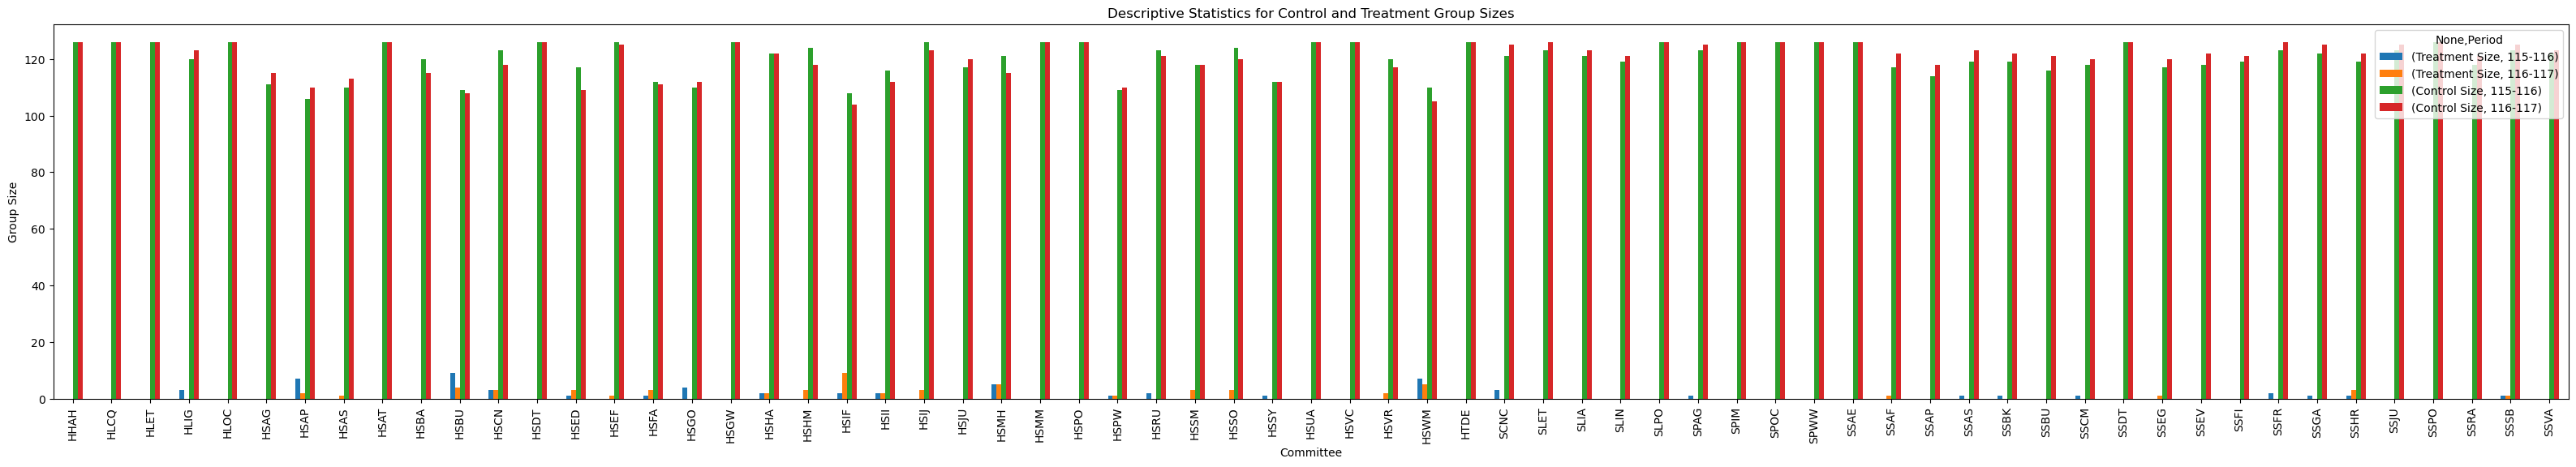

In [ ]:
# Loop over the periods and committees
stats_df = pd.DataFrame(columns=['Committee', 'Period', 'Treatment Size', 'Control Size'])

for pre, post in periods:
    for committee in committees:
        # Perform the DiD analysis and get the descriptive statistics
        coef, p_value, std_error, treatment_size, control_size = perform_did_analysis(pre, post, committee)

        # Add the descriptive statistics to the DataFrame
        stats_df = stats_df.append({
            'Committee': committee,
            'Period': f'{pre}-{post}',
            'Treatment Size': treatment_size,
            'Control Size': control_size
        }, ignore_index=True)

# Pivot the DataFrame to make it easier to plot
stats_pivoted = stats_df.pivot(index='Committee', columns='Period')

# Plot the bar chart
fig, ax = plt.subplots(figsize=(40, 6))
stats_pivoted.plot(kind='bar', ax=ax)
ax.set_xlabel('Committee')
ax.set_ylabel('Group Size')
ax.set_title('Descriptive Statistics for Control and Treatment Group Sizes')
plt.show()

In [ ]:
results_df = results_df.reset_index()

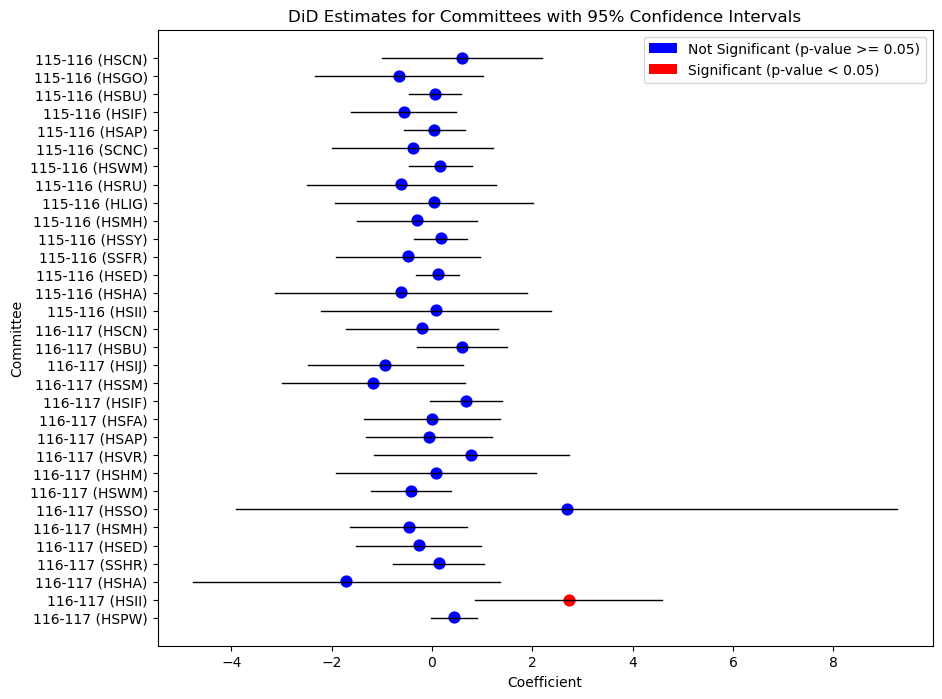

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['red' if significant else 'blue' for significant in results_df['significant']]

# Use the pointplot function to create a cleaner plot with only point estimates and error bars
sns.pointplot(data=results_df, y='y', x='coef', hue='significant', palette={True: 'red', False: 'blue'}, join=False, capsize=.4,errorbar=("pi", 100), dodge=True)

# Add lines for the 95% confidence intervals
for index, row in results_df.iterrows():
    ax.plot((row['lower_ci'], row['upper_ci']), (index, index), color='black', linewidth=1)

ax.set_xlabel('Coefficient')
ax.set_ylabel('Committee')
ax.set_title('DiD Estimates for Committees with 95% Confidence Intervals')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='Not Significant (p-value >= 0.05)'),
    Patch(facecolor='red', label='Significant (p-value < 0.05)'),
]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()


In [ ]:
treatment_df, control_df = get_groups(pre, post, 'HSCN')
# Assuming 'treatment_df' and 'control_df' are your original DataFrames with multiindex
treatment_df = treatment_df.reset_index()
control_df = control_df.reset_index()

# Rename the columns for clarity
treatment_df.columns = ['legislator', 'congress', 'quantity']
control_df.columns = ['legislator', 'congress', 'quantity']

# Create the treatment status and post-treatment dummies for both DataFrames
treatment_df['treatment'] = 1
control_df['treatment'] = 0
treatment_df['post'] = (treatment_df['congress'] == 116).astype(int)
control_df['post'] = (control_df['congress'] == 116).astype(int)

treatment_df
control_df

HSCN


,legislator,congress,quantity,treatment,post
0,B000574,115,2.310497,0,0
1,B000574,116,2.094991,0,1
2,B001274,115,2.739040,0,0
3,B001274,116,2.538809,0,1
4,B001284,116,2.217635,0,1
...,...,...,...,...,...
118,W000802,116,2.615365,0,1
119,W000804,115,2.545164,0,0
120,W000804,116,2.091146,0,1
121,Y000062,115,1.911668,0,0


In [ ]:
quantity_df = pd.concat([treatment_df, control_df])
quantity_df

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Create the interaction term between treatment and post variables
quantity_df['treatment_post'] = quantity_df['treatment'] * quantity_df['post']

# Specify the regression formula
formula = 'quantity ~ treatment + post + treatment_post'

# Run the regression using OLS (Ordinary Least Squares)
result = smf.ols(formula, data=quantity_df).fit()

# Print the summary of the regression results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.4274
Date:                Thu, 30 Mar 2023   Prob (F-statistic):              0.734
Time:                        17:52:18   Log-Likelihood:                -123.94
No. Observations:                 126   AIC:                             255.9
Df Residuals:                     122   BIC:                             267.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.6612      0.086     30.

In [ ]:
treatment_df = pivot_df.loc[pivot_df.index.get_level_values('senator').isin(treatment) & pivot_df.index.get_level_values('congress').isin([pre, post])]
control_df = pivot_df.loc[pivot_df.index.get_level_values('senator').isin(control) & pivot_df.index.get_level_values('congress').isin([pre, post])]

In [ ]:
treatment_df
control_df

committee         Aggregate      HHAH      HLCQ      HLET      HLIG      HLOC  \
senator congress                                                                
B000574 115        1.668207  2.310497  2.310497  2.310497  1.145603  2.310497   
        116        1.630960  2.094991  2.094991  2.094991  0.746009  2.094991   
B001274 115        2.291518  2.739040  2.739040  2.739040  1.017264  2.739040   
        116        1.893815  2.538809  2.538809  2.538809  1.405653  2.538809   
B001284 116        1.607596  2.217635  2.217635  2.217635  0.558254  2.217635   
...                     ...       ...       ...       ...       ...       ...   
W000800 116        1.734318  2.594874  2.594874  2.594874  0.528824  2.594874   
W000804 115        1.847144  2.545164  2.545164  2.545164  0.951724  2.545164   
        116        1.333854  2.091146  2.091146  2.091146  1.190020  2.091146   
Y000062 115        1.533839  1.911668  1.911668  1.911668  3.613613  1.911668   
        116        1.266737  2.034654  2.034654  2.034654  0.744543  2.034654   

committee             HSAG      HSAP      HSAS      HSAT  ...      SSEV  \
senator congress                                          ...             
B000574 115       0.915729  0.904536  0.626156  2.310497  ...  0.742312   
        116       1.627995  0.859952  1.509548  2.094991  ...  1.194899   
B001274 115       1.243656  0.998293  1.905268  2.739040  ...  1.463636   
        116       0.394991  0.720378  1.344242  2.538809  ...  0.862537   
B001284 116       0.485778  0.670388  1.132146  2.217635  ...  0.500383   
...                    ...       ...       ...       ...  ...       ...   
W000800 116       0.971419  0.487247  1.854632  2.594874  ...  0.486484   
W000804 115       0.833324  0.856365  1.299248  2.545164  ...  0.913133   
        116       0.918569  0.713033  1.935673  2.091146  ...  0.778452   
Y000062 115       1.192816  1.089261  1.562192  1.911668  ...  1.800988   
        116       1.327433  0.337460  1.402903  2.034654  ...  0.524634   

committee             SSFI      SSFR      SSGA      SSHR      SSJU      SSPO  \
senator congress                                                               
B000574 115       0.781523  0.392036  0.460780  0.905658  1.155169  2.310497   
        116       0.674030  0.760823  0.840117  0.649949  1.084386  2.094991   
B001274 115       1.040973  1.394090  1.139996  0.764339  1.596578  2.739040   
        116       0.819687  0.703532  1.237799  0.472520  1.523431  2.538809   
B001284 116       0.632745  0.595371  0.933931  0.498113  0.771471  2.217635   
...                    ...       ...       ...       ...       ...       ...   
W000800 116       0.625951  1.131389  0.675188  0.397770  0.670829  2.594874   
W000804 115       0.834370  0.658635  0.722882  1.012047  1.161762  2.545164   
        116       0.447217  0.952782  0.785225  0.938090  0.816739  2.091146   
Y000062 115       0.887576  1.149926  1.091550  0.980916  1.091251  1.911668   
        116       0.511955  0.743672  0.495603  0.515490  0.819876  2.034654   

committee              SSRA      SSSB      SSVA  
senator congress                                 
B000574 115        1.595542  0.647938  0.666029  
        116       12.598025  0.596775  4.524743  
B001274 115        1.300493  1.138092  1.542262  
        116       10.380631  0.546408  3.835431  
B001284 116       11.700431  0.449984  3.088428  
...                     ...       ...       ...  
W000800 116        7.967142  0.447178  1.096735  
W000804 115        0.372279  0.760327  1.031151  
        116        9.854486  0.479502  4.960531  
Y000062 115        5.757342  3.014428  4.008703  
        116       10.448575  0.210645  4.889986  

[119 rows x 66 columns]

In [ ]:
for committee in committees:
    treatment = set(data_pivoted[(data_pivoted[117].apply(lambda x: committee in x if x is not None else False)) &
                                 (data_pivoted[116].apply(lambda x: committee not in x if x is not None else True)) &
                                 (data_pivoted[115].apply(lambda x: committee not in x if x is not None else True)) &
                                 (data_pivoted[117].notnull()) &
                                 (data_pivoted[116].notnull()) &
                                 (data_pivoted[115].notnull())].index)
    
    control = set(data_pivoted[(data_pivoted[117].apply(lambda x: committee not in x if x is not None else True)) & 
                               (data_pivoted[116].apply(lambda x: committee not in x if x is not None else True)) &
                               (data_pivoted[115].apply(lambda x: committee not in x if x is not None else True)) &
                               (data_pivoted[117].notnull()) &
                               (data_pivoted[116].notnull()) &
                               (data_pivoted[115].notnull())].index)
    
    treatment_df = pivot_df.loc[pivot_df.index.get_level_values('senator').isin(treatment) & pivot_df.index.get_level_values('congress').isin([115, 116, 117])]
    control_df = pivot_df.loc[pivot_df.index.get_level_values('senator').isin(control) & pivot_df.index.get_level_values('congress').isin([115, 116, 117])]
    
    if len(treatment_df) > 0 and len(control_df) > 0:
        print(f"Using committee '{committee}'")
        break


Using committee 'SSEG'


0


In [ ]:
# Compute the DiD estimate
pre_treatment_difference = treatment_df.loc[[115, 116]].mean() - control_ce.loc[[115, 116]].mean()
post_treatment_difference = treatment_ce.loc[[117]].mean() - control_ce.loc[[117]].mean()
did_estimate = post_treatment_difference - pre_treatment_difference

# Check the parallel trend assumption
plt.plot([115, 116, 117], [control_ce.loc[[115, 116, 117]].mean(), control_ce.loc[[115, 116, 117]].mean(), control_ce.loc[[115, 116, 117]].mean()], label='Control')
plt.plot([115, 116, 117], [treatment_ce.loc[[115, 116, 117]].mean(), treatment_ce.loc[[115, 116, 117]].mean(), treatment_ce.loc[[115, 116, 117]].mean()], label='Treatment')
plt.legend()
plt.xlabel('Congress Period')
plt.ylabel('Cross-Entropy')
plt.title('Parallel Trend Assumption')
plt.show()


In [ ]:
def perform_did_analysis(committee):
    # Identify the treatment and control groups based on the committee of interest
    hsag_treatment = set(pivot_df[(pivot_df[117].apply(lambda x: committee in x if x is not None else False)) &
                                  (pivot_df[116].apply(lambda x: committee not in x if x is not None else True)) &
                                  (pivot_df[115].apply(lambda x: committee not in x if x is not None else True))].index)
    hsag_control = set(pivot_df[(pivot_df[117].apply(lambda x: committee not in x if x is not None else True)) & 
                               (pivot_df[116].apply(lambda x: committee not in x if x is not None else True)) &
                               (pivot_df[115].apply(lambda x: committee not in x if x is not None else True))].index)

    # Subset the data to only include the treatment and control groups for the relevant periods
    treatment_df = pivot_df.loc[pivot_df.index.get_level_values('bioguide_id').isin(hsag_treatment) & pivot_df.index.get_level_values('congress').isin([115, 116, 117])]
    control_df = pivot_df.loc[pivot_df.index.get_level_values('bioguide_id').isin(hsag_control) & pivot_df.index.get_level_values('congress').isin([115, 116, 117])]

    print(treatment_df)

    # Compute the average cross-entropy for the treatment and control groups for the relevant periods
    treatment_ce = treatment_df[committee].mean(level='congress')
    control_ce = control_df[committee].mean(level='congress')

    # Compute the DiD estimate
    pre_treatment_difference = treatment_ce.loc[[115, 116]].mean() - control_ce.loc[[115, 116]].mean()
    post_treatment_difference = treatment_ce.loc[[117]].mean() - control_ce.loc[[117]].mean()
    did_estimate = post_treatment_difference - pre_treatment_difference

    # Check the parallel trend assumption
    plt.plot([115, 116, 117], [control_ce.loc[[115, 116, 117]].mean(), control_ce.loc[[115, 116, 117]].mean(), control_ce.loc[[115, 116, 117]].mean()], label='Control')
    plt.plot([115, 116, 117], [treatment_ce.loc[[115, 116, 117]].mean(), treatment_ce.loc[[115, 116, 117]].mean(), treatment_ce.loc[[115, 116, 117]].mean()], label='Treatment')
    plt.legend()
    plt.xlabel('Congress Period')
    plt.ylabel('Cross-Entropy')
    plt.title('Parallel Trend Assumption')
    plt.show()

    return did_estimate


HSCN


KeyError: 117

31
639


{'A000370',
 'A000372',
 'A000374',
 'B001286',
 'B001295',
 'B001298',
 'C001059',
 'C001062',
 'C001087',
 'C001108',
 'D000616',
 'D000619',
 'D000628',
 'F000455',
 'H001053',
 'K000388',
 'L000578',
 'L000586',
 'M000312',
 'M001185',
 'M001198',
 'O000171',
 'P000258',
 'P000610',
 'P000613',
 'R000603',
 'S001157',
 'S001189',
 'T000467',
 'V000132',
 'Y000065'}

In [ ]:
pivot_df

committee         Aggregate      HHAH      HLCQ      HLET      HLIG      HLOC  \
senator congress                                                                
A000076 116             NaN  2.838487  2.838487  2.838487  0.761769  2.838487   
        117             NaN  1.994510  1.994510  1.994510  0.521573  1.994510   
A000364 116             NaN  2.080461  2.080461  2.080461  0.945896  2.080461   
A000367 115        1.770435  2.526808  2.526808  2.526808  0.851615  2.526808   
        116             NaN  2.492253  2.492253  2.492253  0.713247  2.492253   
...                     ...       ...       ...       ...       ...       ...   
Y000062 115        1.533839  1.911668  1.911668  1.911668  3.613613  1.911668   
        116        1.266737  2.034654  2.034654  2.034654  0.744543  2.034654   
        117        1.448163  2.189661  2.189661  2.189661  0.939949  2.189661   
Y000063 114             NaN  3.268878  3.268878  3.268878  1.074649  3.268878   
        115        2.367116  3.016054  3.016054  3.016054  2.254583  3.016054   

committee             HSAG      HSAP      HSAS      HSAT  ...      SSEV  \
senator congress                                          ...             
A000076 116       1.124205  0.843289  2.437729  2.838487  ...  0.700261   
        117       1.040841  0.628032  0.404431  1.994510  ...  0.908134   
A000364 116       0.574210  0.743707  1.839397  2.080461  ...  0.655662   
A000367 115       0.833049  0.838817  1.323293  2.526808  ...  0.826874   
        116       1.049994  1.174849  1.539766  2.492253  ...  0.449228   
...                    ...       ...       ...       ...  ...       ...   
Y000062 115       1.192816  1.089261  1.562192  1.911668  ...  1.800988   
        116       1.327433  0.337460  1.402903  2.034654  ...  0.524634   
        117       1.443406  0.917788  0.708776  2.189661  ...  1.017068   
Y000063 114       0.709191  1.115307  3.373584  3.268878  ...  1.434535   
        115       1.325228  0.965332  0.983607  3.016054  ...  1.925699   

committee             SSFI      SSFR      SSGA      SSHR      SSJU      SSPO  \
senator congress                                                               
A000076 116       0.747220  1.010105  0.925417  0.464875  0.679325  2.838487   
        117       0.932682  4.017124  0.546993  0.573883  0.662098  1.994510   
A000364 116       0.175522  1.021154  0.591030  0.530559  0.666639  2.080461   
A000367 115       0.901126  0.785693  0.825169  1.040361  1.000287  2.526808   
        116       0.865982  1.315268  0.817794  0.740687  0.897260  2.492253   
...                    ...       ...       ...       ...       ...       ...   
Y000062 115       0.887576  1.149926  1.091550  0.980916  1.091251  1.911668   
        116       0.511955  0.743672  0.495603  0.515490  0.819876  2.034654   
        117       1.201255  3.937793  0.431914  1.087356  0.959601  2.189661   
Y000063 114       1.133967  0.576989  1.290782  1.280473  0.882297  3.268878   
        115       1.236722  0.956680  1.074659  0.813844  2.818082  3.016054   

committee              SSRA      SSSB      SSVA  
senator congress                                 
A000076 116        6.641782  0.735877  1.161677  
        117        9.210612  6.179240  8.430289  
A000364 116       10.927072  0.299179  3.226855  
A000367 115        0.291676  0.664019  1.056676  
        116       13.373932  0.652843  0.785270  
...                     ...       ...       ...  
Y000062 115        5.757342  3.014428  4.008703  
        116       10.448575  0.210645  4.889986  
        117        7.718390  4.867120  5.925283  
Y000063 114        9.668030  1.357093  0.940208  
        115        1.285354  1.599377  0.838250  

[339 rows x 66 columns]

In [ ]:
# Subset the pivot_df dataframe to only include rows where senator is in the treatment group and congress is 115, 116, or 117
treatment_df = pivot_df.loc[pivot_df.index.get_level_values('senator').isin(treatment) & pivot_df.index.get_level_values('congress').isin([115, 116, 117])]
control_df = pivot_df.loc[pivot_df.index.get_level_values('senator').isin(control) & pivot_df.index.get_level_values('congress').isin([115, 116, 117])]

In [ ]:
control_df

committee         Aggregate      HHAH      HLCQ      HLET      HLIG      HLOC  \
senator congress                                                                
A000367 115        1.770435  2.526808  2.526808  2.526808  0.851615  2.526808   
        116             NaN  2.492253  2.492253  2.492253  0.713247  2.492253   
B000574 115        1.668207  2.310497  2.310497  2.310497  1.145603  2.310497   
        116        1.630960  2.094991  2.094991  2.094991  0.746009  2.094991   
        117        1.412445  2.097616  2.097616  2.097616  0.556061  2.097616   
...                     ...       ...       ...       ...       ...       ...   
W000804 117        1.441376  2.233967  2.233967  2.233967  0.795342  2.233967   
Y000062 115        1.533839  1.911668  1.911668  1.911668  3.613613  1.911668   
        116        1.266737  2.034654  2.034654  2.034654  0.744543  2.034654   
        117        1.448163  2.189661  2.189661  2.189661  0.939949  2.189661   
Y000063 115        2.367116  3.016054  3.016054  3.016054  2.254583  3.016054   

committee             HSAG      HSAP      HSAS      HSAT  ...      SSEV  \
senator congress                                          ...             
A000367 115       0.833049  0.838817  1.323293  2.526808  ...  0.826874   
        116       1.049994  1.174849  1.539766  2.492253  ...  0.449228   
B000574 115       0.915729  0.904536  0.626156  2.310497  ...  0.742312   
        116       1.627995  0.859952  1.509548  2.094991  ...  1.194899   
        117       0.785262  0.857809  0.420752  2.097616  ...  0.583458   
...                    ...       ...       ...       ...  ...       ...   
W000804 117       0.975687  0.411731  0.547341  2.233967  ...  0.838418   
Y000062 115       1.192816  1.089261  1.562192  1.911668  ...  1.800988   
        116       1.327433  0.337460  1.402903  2.034654  ...  0.524634   
        117       1.443406  0.917788  0.708776  2.189661  ...  1.017068   
Y000063 115       1.325228  0.965332  0.983607  3.016054  ...  1.925699   

committee             SSFI      SSFR      SSGA      SSHR      SSJU      SSPO  \
senator congress                                                               
A000367 115       0.901126  0.785693  0.825169  1.040361  1.000287  2.526808   
        116       0.865982  1.315268  0.817794  0.740687  0.897260  2.492253   
B000574 115       0.781523  0.392036  0.460780  0.905658  1.155169  2.310497   
        116       0.674030  0.760823  0.840117  0.649949  1.084386  2.094991   
        117       0.768322  3.084829  0.753021  0.414768  0.375741  2.097616   
...                    ...       ...       ...       ...       ...       ...   
W000804 117       0.980319  2.498398  0.196615  0.684867  0.425551  2.233967   
Y000062 115       0.887576  1.149926  1.091550  0.980916  1.091251  1.911668   
        116       0.511955  0.743672  0.495603  0.515490  0.819876  2.034654   
        117       1.201255  3.937793  0.431914  1.087356  0.959601  2.189661   
Y000063 115       1.236722  0.956680  1.074659  0.813844  2.818082  3.016054   

committee              SSRA      SSSB      SSVA  
senator congress                                 
A000367 115        0.291676  0.664019  1.056676  
        116       13.373932  0.652843  0.785270  
B000574 115        1.595542  0.647938  0.666029  
        116       12.598025  0.596775  4.524743  
        117        8.746913  6.188695  7.336762  
...                     ...       ...       ...  
W000804 117        5.866164  2.726306  3.744350  
Y000062 115        5.757342  3.014428  4.008703  
        116       10.448575  0.210645  4.889986  
        117        7.718390  4.867120  5.925283  
Y000063 115        1.285354  1.599377  0.838250  

[201 rows x 66 columns]

In [ ]:
# Compute the average cross-entropy for HSAG for the treatment and control groups for 115th, 116th, and 117th congress
treatment_ce_115 = treatment_df['HSAG'].loc[(slice(None), 115)].mean()
control_ce_115 = control_df['HSAG'].loc[(slice(None), 115)].mean()
treatment_ce_116 = treatment_df['HSAG'].loc[(slice(None), 116)].mean()
control_ce_116 = control_df['HSAG'].loc[(slice(None), 116)].mean()
treatment_ce_117 = treatment_df['HSAG'].loc[(slice(None), 117)].mean()
control_ce_117 = control_df['HSAG'].loc[(slice(None), 117)].mean()

KeyError: 115

Treatment effect: 0.05081812493896409


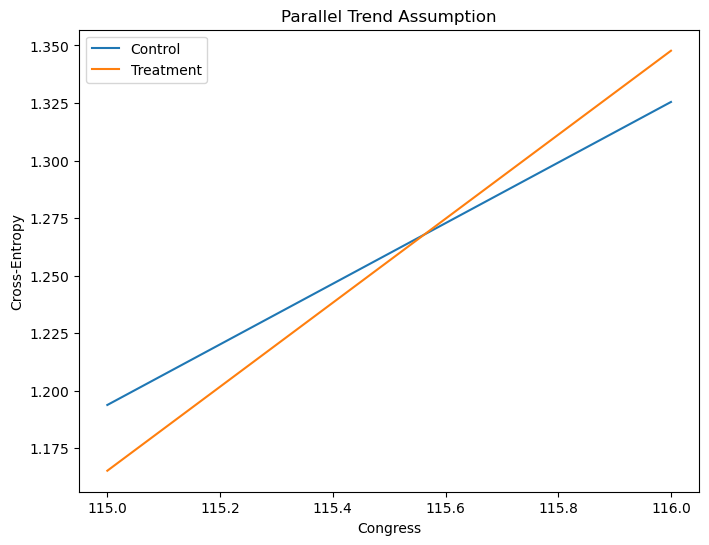

In [ ]:
import matplotlib.pyplot as plt

# Compute the treatment effect
treatment_effect = treatment_ce_116 - treatment_ce_115 - (control_ce_116 - control_ce_115)
print(f'Treatment effect: {treatment_effect}')

# Visualize parallel trend assumption
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([115, 116], [control_ce_115, control_ce_116], label='Control')
ax.plot([115, 116], [treatment_ce_115, treatment_ce_116], label='Treatment')
ax.set_xlabel('Congress')
ax.set_ylabel('Cross-Entropy')
ax.set_title('Parallel Trend Assumption')
ax.legend()
plt.show()

In [ ]:

# Define a function to compare the committees while accounting for NaNs and order
def compare_committees(row, period1, period2):
    committees1 = row[period1]
    committees2 = row[period2]
    
    if not committees1 or not committees2:
        return False  # exclude non-incumbents
    # print(committees1, committees2)
    set_committees1 = set(committees1)
    set_committees2 = set(committees2)
    
    return set_committees1 != set_committees2

# Create columns representing treatment and control groups for 115-116 and 116-117 periods
data_pivoted['treatment_115_116'] = data_pivoted.apply(lambda row: compare_committees(row, 115, 116), axis=1)
data_pivoted['treatment_116_117'] = data_pivoted.apply(lambda row: compare_committees(row, 116, 117), axis=1)


In [ ]:
data_pivoted

congress_num,113,114,115,116,117,treatment_115_116,treatment_116_117
legislator_bioguide_id,,,,,,,
A000055,None,None,"[JCSE, HSAP]",[HSAP],[HSAP],True,False
A000148,None,None,None,None,"[HSBA, HSPW]",False,False
A000360,None,None,"[SSRA, SSHR, SSAP, SSEG]","[SSAP, SSHR, SSEG, SSRA]",None,False,False
A000367,None,None,"[HSGO, JSEC]",None,None,False,False
A000369,None,None,[HSAP],[HSAP],[HSAP],False,False
...,...,...,...,...,...,...,...
Y000063,None,None,[HSAP],None,None,False,False
Y000064,None,None,"[SSSB, SSHR, SSFR, SSCM]","[SSFI, SSFR, SSSB, SSCM]","[SSSB, SSFR, SSCM, SSFI]",True,False
Y000065,None,None,"[HSFA, HSAG]","[HSFA, HSAG]",None,False,False


Number of congresspersons in treatment group for 115-116 period: 193
Number of congresspersons in control group for 115-116 period: 508
Number of congresspersons in treatment group for 116-117 period: 201
Number of congresspersons in control group for 116-117 period: 500


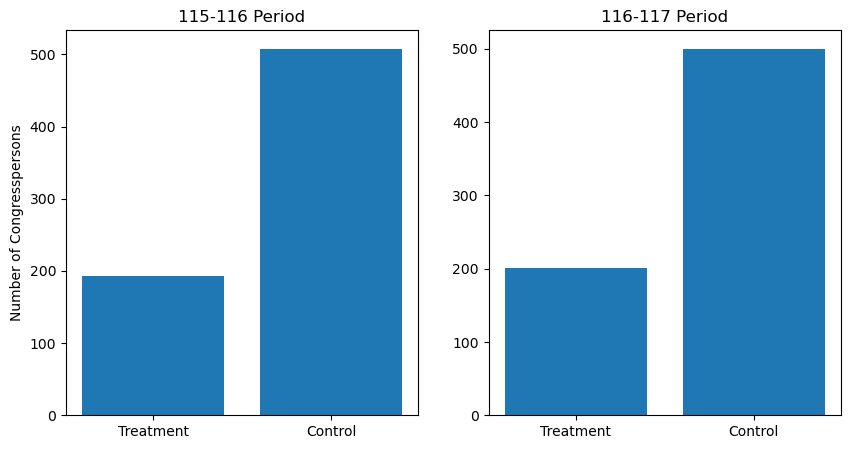

In [ ]:
import matplotlib.pyplot as plt

# Define treatment and control groups for 115-116 period
treatment_group_115_116 = data_pivoted[data_pivoted['treatment_115_116']]
control_group_115_116 = data_pivoted[~data_pivoted['treatment_115_116']]

# Define treatment and control groups for 116-117 period
treatment_group_116_117 = data_pivoted[data_pivoted['treatment_116_117']]
control_group_116_117 = data_pivoted[~data_pivoted['treatment_116_117']]

# Calculate the number of congresspersons in each group
num_treatment_115_116 = len(treatment_group_115_116)
num_control_115_116 = len(control_group_115_116)
num_treatment_116_117 = len(treatment_group_116_117)
num_control_116_117 = len(control_group_116_117)

print(f'Number of congresspersons in treatment group for 115-116 period: {num_treatment_115_116}')
print(f'Number of congresspersons in control group for 115-116 period: {num_control_115_116}')
print(f'Number of congresspersons in treatment group for 116-117 period: {num_treatment_116_117}')
print(f'Number of congresspersons in control group for 116-117 period: {num_control_116_117}')

# Create bar charts for each period
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Bar chart for 115-116 period
ax1.bar(['Treatment', 'Control'], [num_treatment_115_116, num_control_115_116])
ax1.set_title('115-116 Period')
ax1.set_ylabel('Number of Congresspersons')

# Bar chart for 116-117 period
ax2.bar(['Treatment', 'Control'], [num_treatment_116_117, num_control_116_117])
ax2.set_title('116-117 Period')

plt.show()


In [ ]:
committee_counts = (
    data_pivoted[[115, 116, 117]]
    .stack()
    .apply(pd.Series)
    .stack()
    .reset_index()
    .rename(columns={"level_1": "congress", 0: "committee"})
    .groupby(["congress_num", "committee"])
    .size()
    .reset_index(name="count")
)


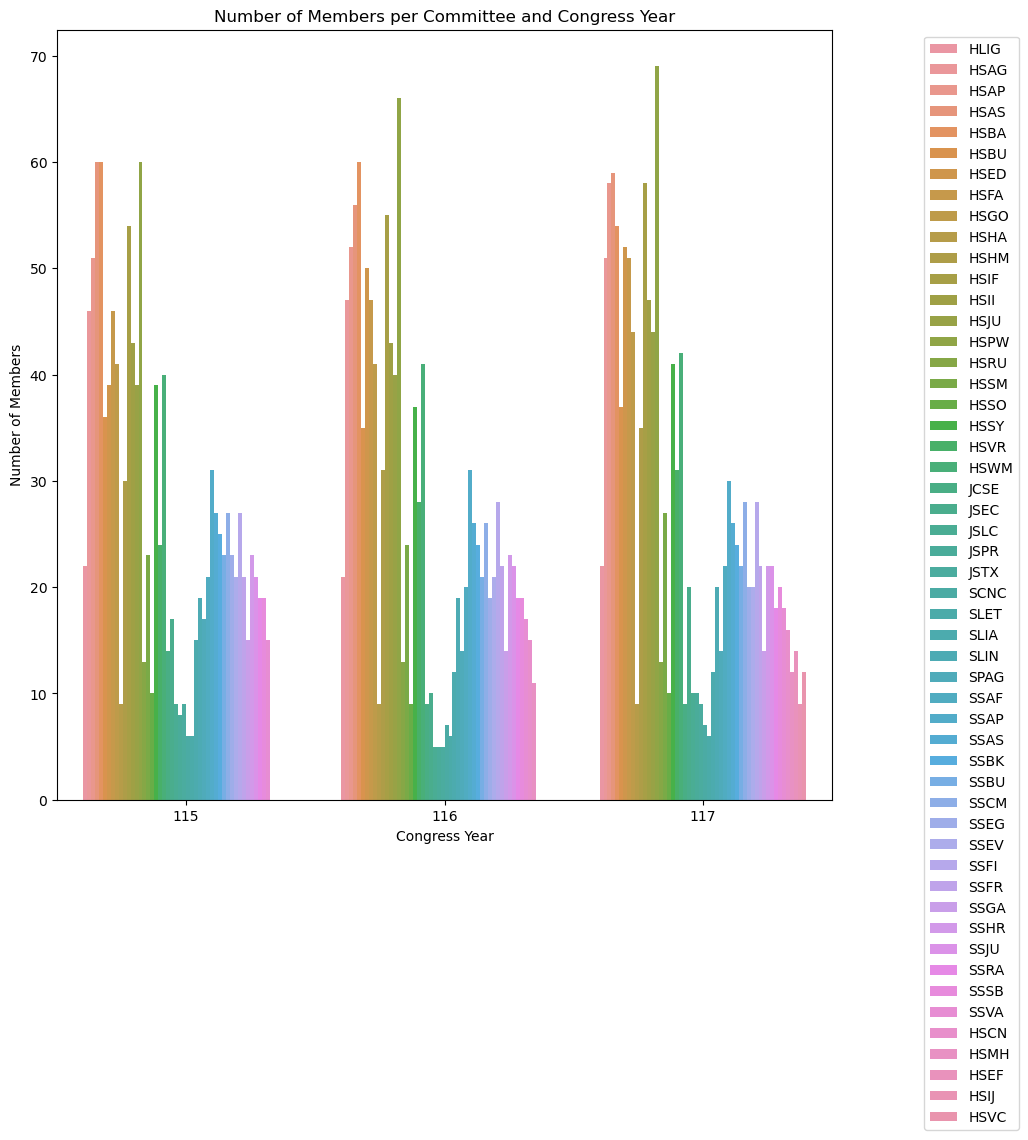

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.barplot(data=committee_counts, x="congress_num", y="count", hue="committee")
plt.xlabel("Congress Year")
plt.ylabel("Number of Members")
plt.title("Number of Members per Committee and Congress Year")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.show()


In [ ]:
df

committee         Aggregate      HHAH      HLCQ      HLET      HLIG      HLOC  \
senator congress                                                                
A000076 116             NaN  2.838487  2.838487  2.838487  0.761769  2.838487   
        117             NaN  1.994510  1.994510  1.994510  0.521573  1.994510   
A000364 116             NaN  2.080461  2.080461  2.080461  0.945896  2.080461   
A000367 115        1.770435  2.526808  2.526808  2.526808  0.851615  2.526808   
        116             NaN  2.492253  2.492253  2.492253  0.713247  2.492253   
...                     ...       ...       ...       ...       ...       ...   
Y000062 115        1.533839  1.911668  1.911668  1.911668  3.613613  1.911668   
        116        1.266737  2.034654  2.034654  2.034654  0.744543  2.034654   
        117        1.448163  2.189661  2.189661  2.189661  0.939949  2.189661   
Y000063 114             NaN  3.268878  3.268878  3.268878  1.074649  3.268878   
        115        2.367116  3.016054  3.016054  3.016054  2.254583  3.016054   

committee             HSAG      HSAP      HSAS      HSAT  ...      SSFR  \
senator congress                                          ...             
A000076 116       1.124205  0.843289  2.437729  2.838487  ...  1.010105   
        117       1.040841  0.628032  0.404431  1.994510  ...  4.017124   
A000364 116       0.574210  0.743707  1.839397  2.080461  ...  1.021154   
A000367 115       0.833049  0.838817  1.323293  2.526808  ...  0.785693   
        116       1.049994  1.174849  1.539766  2.492253  ...  1.315268   
...                    ...       ...       ...       ...  ...       ...   
Y000062 115       1.192816  1.089261  1.562192  1.911668  ...  1.149926   
        116       1.327433  0.337460  1.402903  2.034654  ...  0.743672   
        117       1.443406  0.917788  0.708776  2.189661  ...  3.937793   
Y000063 114       0.709191  1.115307  3.373584  3.268878  ...  0.576989   
        115       1.325228  0.965332  0.983607  3.016054  ...  0.956680   

committee             SSGA      SSHR      SSJU      SSPO       SSRA      SSSB  \
senator congress                                                                
A000076 116       0.925417  0.464875  0.679325  2.838487   6.641782  0.735877   
        117       0.546993  0.573883  0.662098  1.994510   9.210612  6.179240   
A000364 116       0.591030  0.530559  0.666639  2.080461  10.927072  0.299179   
A000367 115       0.825169  1.040361  1.000287  2.526808   0.291676  0.664019   
        116       0.817794  0.740687  0.897260  2.492253  13.373932  0.652843   
...                    ...       ...       ...       ...        ...       ...   
Y000062 115       1.091550  0.980916  1.091251  1.911668   5.757342  3.014428   
        116       0.495603  0.515490  0.819876  2.034654  10.448575  0.210645   
        117       0.431914  1.087356  0.959601  2.189661   7.718390  4.867120   
Y000063 114       1.290782  1.280473  0.882297  3.268878   9.668030  1.357093   
        115       1.074659  0.813844  2.818082  3.016054   1.285354  1.599377   

committee             SSVA  AssignedCommitteesCount  \
senator congress                                      
A000076 116       1.161677                      0.0   
        117       8.430289                      0.0   
A000364 116       3.226855                      0.0   
A000367 115       1.056676                      2.0   
        116       0.785270                      0.0   
...                    ...                      ...   
Y000062 115       4.008703                      1.0   
        116       4.889986                      1.0   
        117       5.925283                      2.0   
Y000063 114       0.940208                      0.0   
        115       0.838250                      1.0   

committee         LaggedAssignedCommitteesCount  
senator congress                                 
A000076 116                                 0.0  
        117                                 0.0  
